In [45]:
# import matplotlib.pyplot as plt
# import numpy as np
# import cv2
# import tensorflow as tf
# from sklearn.metrics import f1_score 
# from tensorflow.keras import optimizers
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

In [18]:
import os
import pytesseract
from ultralytics import YOLO

# مسیر tesseract.exe (برای ویندوز)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

yolo_model = YOLO("license-plate-finetune-v1x.pt")

In [ ]:
def detect_plate(img, text=''):
    plate_img = img.copy()
    roi = img.copy()
    

    # 🔄 استفاده از YOLO به‌جای cascade
    # results = yolo_model(img)[0]
    yolo_model.to('cpu') 
    results = yolo_model(img)
    plate = None

    for box in results[0].boxes:
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        # می‌تونی فقط کلاس خاص پلاک رو فیلتر کنی (اگر کلاس‌بندی‌شده باشه)
        roi_ = roi[y1:y2, x1:x2, :]
        plate = roi[y1:y2, x1:x2]

        cv2.rectangle(plate_img, (x1, y1), (x2, y2), (51,181,155), 3)

        if text != '':
            plate_img = cv2.putText(plate_img, text, (x1, y1 - 10),
                                    cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                    0.5, (51,181,155), 1, cv2.LINE_AA)

        break  # فقط اولین پلاک رو بگیره

    return plate_img, plate


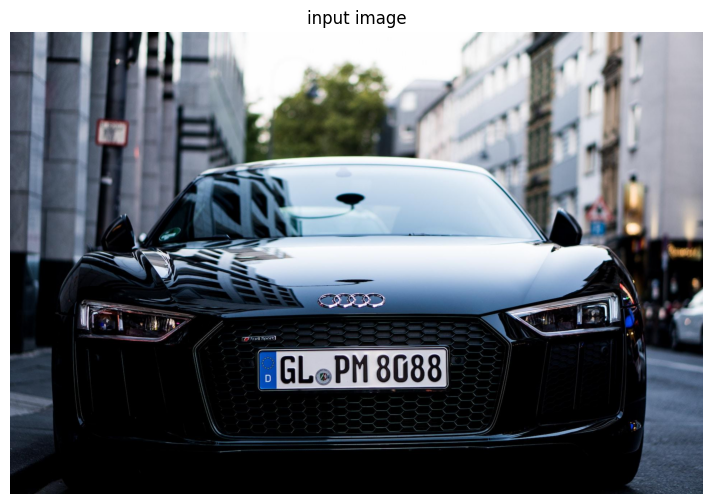

In [16]:
import matplotlib.pyplot as plt
import cv2
# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

img = cv2.imread('./temp.jpg')
display(img, 'input image')

In [17]:
print(type(img), img.dtype, img.shape)

<class 'numpy.ndarray'> uint8 (1280, 1920, 3)


In [18]:
# Getting plate prom the processed image
output_img, plate = detect_plate(img)


0: 448x640 1 License_Plate, 1476.9ms
Speed: 5.9ms preprocess, 1476.9ms inference, 5.0ms postprocess per image at shape (1, 3, 448, 640)


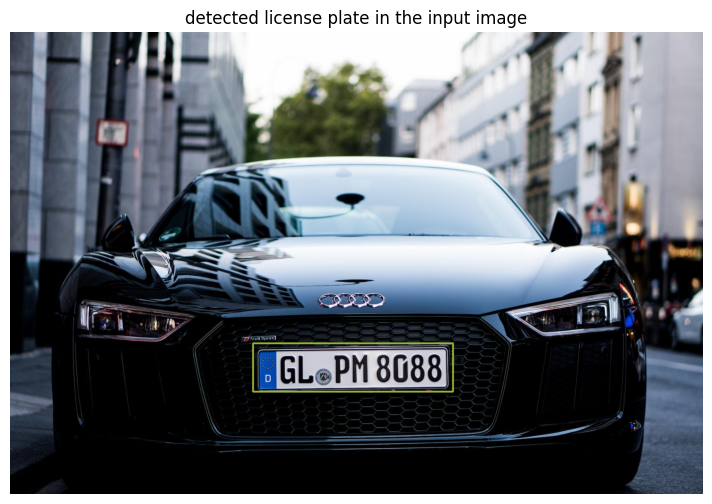

In [19]:
display(output_img, 'detected license plate in the input image')

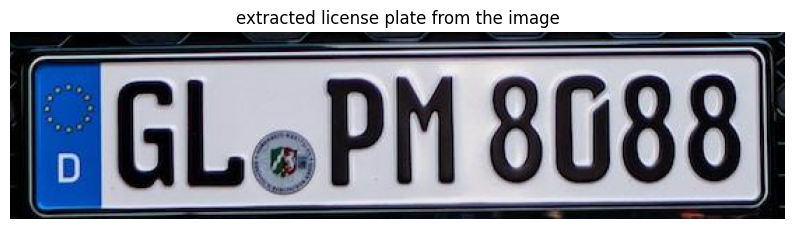

In [140]:
display(plate, 'extracted license plate from the image')

In [52]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [22]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

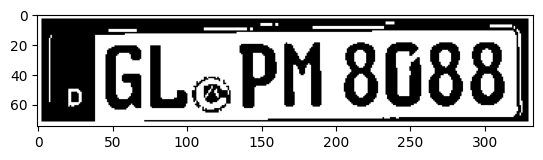

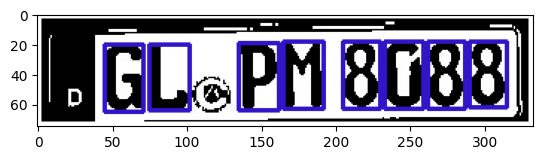

In [23]:
import numpy as np
# Let's see the segmented characters
char = segment_characters(plate)

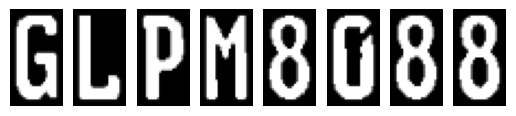

In [144]:
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

### Model for characters

In [72]:
import tensorflow.keras.backend as K
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = './data/data'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [24]:
# Metrics for checking the model performance while training
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

In [73]:
# K.clear_session()
# model = Sequential()
# model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(4, 4)))
# model.add(Dropout(0.4))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(36, activation='softmax'))

# model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=[custom_f1score])

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers
from tensorflow.keras import backend as K

K.clear_session()

classifier_model = Sequential()

# Block 1
classifier_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)))
classifier_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
classifier_model.add(MaxPooling2D(pool_size=(2, 2)))
classifier_model.add(Dropout(0.25))

# Block 2
classifier_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
classifier_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
classifier_model.add(MaxPooling2D(pool_size=(2, 2)))
classifier_model.add(Dropout(0.25))

# FC Head
classifier_model.add(Flatten())
classifier_model.add(Dense(256, activation='relu'))
classifier_model.add(Dropout(0.5))
classifier_model.add(Dense(36, activation='softmax'))

# Compile
classifier_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)


In [26]:
pip install prettytable

Note: you may need to restart the kernel to use updated packages.


In [27]:

from prettytable import PrettyTable
def count_parameters(classifier_model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in classifier_model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [74]:
classifier_model.summary()
# count_parameters(classifier_model)
# classifier_model.summary(line_length=180, expand_nested=True)  # ستون‌ها عریض‌تر؛ کمتر wrap می‌شود


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

In [75]:
stringlist = []
classifier_model.summary(line_length=180, expand_nested=True,
              print_fn=lambda x: stringlist.append(x))
open('model_summary.txt','w').write("\n".join(stringlist))


5340

In [76]:
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_custom_f1score') > 0.99):
      self.classifier_model.stop_training = True

In [8]:
import tensorflow as tf

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.cast(y_true, tf.int64)

        tp = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
        fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.not_equal(y_true, y_pred), tf.not_equal(y_pred, 0)), tf.float32))
        fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.not_equal(y_true, y_pred), tf.not_equal(y_true, 0)), tf.float32))

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + 1e-8)
        recall = self.true_positives / (self.true_positives + self.false_negatives + 1e-8)
        return 2 * precision * recall / (precision + recall + 1e-8)

    def reset_states(self):
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)


In [ ]:
# class stop_training_callback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         f1 = logs.get('val_custom_f1score')
#         if f1 is not None and f1 > 0.999:
#             print(f"\nEarly stopping: val_custom_f1score reached {f1}")
#             self.classifier_model.stop_training = True



# classifier_model.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=tf.keras.optimizers.Adam(1e-4),
#     metrics=[F1Score(name='val_custom_f1score'), 'accuracy']
# )


In [ ]:
# batch_size = 1
# callbacks = [stop_training_callback()]
# classifier_model.fit_generator(
#       train_generator,
#       steps_per_epoch = train_generator.samples // batch_size,
#       validation_data = validation_generator, 
#       epochs = 80, verbose=1, callbacks=callbacks)


Epoch 1/80


C:\Users\Mohammad Hossein\AppData\Local\Temp\ipykernel_16776\920004014.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


864/864 [==============================] - ETA: 0s - loss: 3.4238 - val_custom_f1score: 0.0938 - accuracy: 0.0891

c:\Users\Mohammad Hossein\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py:2416: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


864/864 [==============================] - 31s 34ms/step - loss: 3.4238 - val_custom_f1score: 0.0938 - accuracy: 0.0891 - val_loss: 2.8285 - val_val_custom_f1score: 0.0360 - val_accuracy: 0.3519
Epoch 2/80
864/864 [==============================] - 49s 57ms/step - loss: 2.2759 - val_custom_f1score: 0.3805 - accuracy: 0.3704 - val_loss: 1.3561 - val_val_custom_f1score: 0.0520 - val_accuracy: 0.7130
Epoch 3/80
864/864 [==============================] - 52s 60ms/step - loss: 1.3597 - val_custom_f1score: 0.6164 - accuracy: 0.6053 - val_loss: 0.6945 - val_val_custom_f1score: 0.0499 - val_accuracy: 0.8241
Epoch 4/80
864/864 [==============================] - 43s 50ms/step - loss: 1.0434 - val_custom_f1score: 0.6934 - accuracy: 0.6794 - val_loss: 0.4116 - val_val_custom_f1score: 0.0528 - val_accuracy: 0.8935
Epoch 5/80
864/864 [==============================] - 42s 49ms/step - loss: 0.7837 - val_custom_f1score: 0.7625 - accuracy: 0.7523 - val_loss: 0.3520 - val_val_custom_f1score: 0.0522 - va

KeyboardInterrupt: 

In [81]:
import tensorflow as tf
# اگر از tfa استفاده می‌کنی:
# from tensorflow_addons.metrics import F1Score as TFAF1Score
# metrics=[TFAF1Score(num_classes=NUM_CLASSES, average='macro', name='custom_f1score'), 'accuracy']

class StopOnF1(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        f1 = logs.get('val_custom_f1score')
        if f1 is not None and f1 > 0.9995:
            print(f"\nEarly stopping: val_custom_f1score reached {float(f1):.4f}")
            self.model.stop_training = True

classifier_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=[F1Score(name='custom_f1score'), 'accuracy']  # << بدون "val_"
)

batch_size = 1
callbacks = [StopOnF1()]
history = classifier_model.fit(  # fit_generator قدیمی شده
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    epochs=80, verbose=1, callbacks=callbacks
)


Epoch 1/80
862/864 [============================>.] - ETA: 0s - loss: 0.0391 - custom_f1score: 0.9877 - accuracy: 0.9814

c:\Users\Mohammad Hossein\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py:2416: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


864/864 [==============================] - 10s 11ms/step - loss: 0.0390 - custom_f1score: 0.9878 - accuracy: 0.9815 - val_loss: 0.0130 - val_custom_f1score: 0.0581 - val_accuracy: 0.9954
Epoch 2/80
864/864 [==============================] - 6s 7ms/step - loss: 0.0480 - custom_f1score: 0.9866 - accuracy: 0.9769 - val_loss: 0.0114 - val_custom_f1score: 0.0571 - val_accuracy: 1.0000
Epoch 3/80
864/864 [==============================] - 6s 7ms/step - loss: 0.0551 - custom_f1score: 0.9860 - accuracy: 0.9780 - val_loss: 0.0123 - val_custom_f1score: 0.0598 - val_accuracy: 0.9954
Epoch 4/80
864/864 [==============================] - 6s 7ms/step - loss: 0.0342 - custom_f1score: 0.9930 - accuracy: 0.9861 - val_loss: 0.0146 - val_custom_f1score: 0.0538 - val_accuracy: 0.9954
Epoch 5/80
864/864 [==============================] - 6s 7ms/step - loss: 0.0437 - custom_f1score: 0.9901 - accuracy: 0.9838 - val_loss: 0.0201 - val_custom_f1score: 0.0518 - val_accuracy: 0.9907
Epoch 6/80
864/864 [=========

In [82]:
import os
import json

os.makedirs("analyze/classifier", exist_ok=True)

# پیشنهاد: فرمت جدید Keras
classifier_model.save("analyze/classifier/classifier.keras")
# یا اگر دوست داری h5:
# classifier_model.save("analyze/classifier.h5")


# ۱. مپ کلاس‌ها
with open("analyze/classifier/class_indices.json", "w") as f:
    json.dump(train_generator.class_indices, f)

# ۲. هر تنظیم مهمی که بعداً لازم داری (input shape, num_classes, ... )
config = {
    "input_shape": classifier_model.input_shape[1:],  # مثلا (224, 224, 3)
    "num_classes": classifier_model.output_shape[-1],
}
with open("analyze/classifier/classifier_config.json", "w") as f:
    json.dump(config, f)



In [83]:
import tensorflow as tf
import json

classifier_model = tf.keras.models.load_model("analyze/classifier/classifier.keras",
                                   custom_objects={"F1Score": F1Score})

with open("analyze/classifier/class_indices.json") as f:
    class_indices = json.load(f)
# اگر خواستی برگردونی از index به label:
idx_to_class = {v: k for k, v in class_indices.items()}


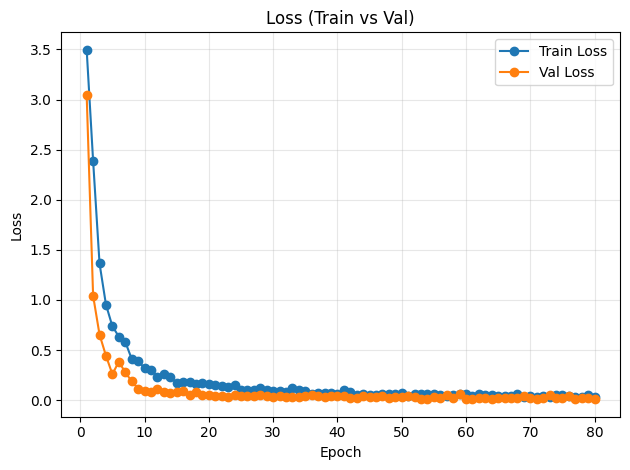

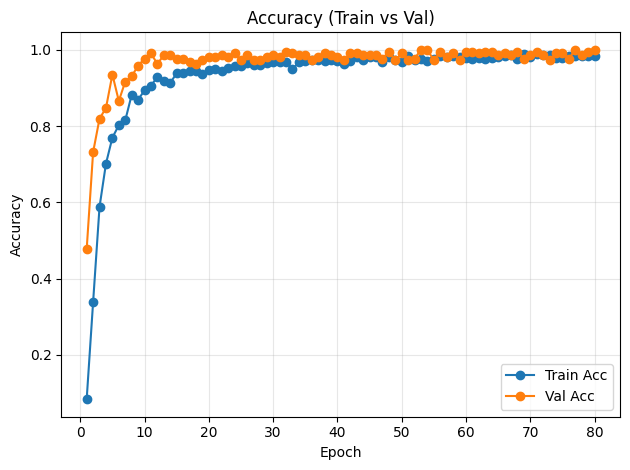

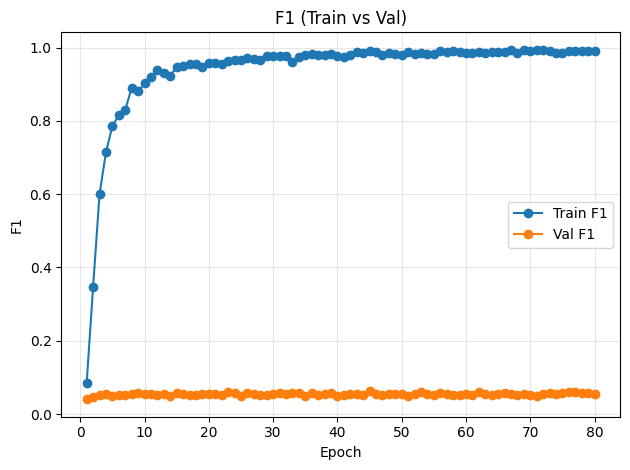

In [ ]:
import matplotlib.pyplot as plt

# history همان خروجی model.fit(...) است
H = history.history
epochs = range(1, len(H['loss']) + 1)

# --- Loss ---
plt.figure()
plt.plot(epochs, H['loss'], marker='o', label='Train Loss')
plt.plot(epochs, H['val_loss'], marker='o', label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss (Train vs Val)')
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig("analyze/classifier/loss_curve.png", dpi=300)
plt.show()

# --- Accuracy ---
plt.figure()
plt.plot(epochs, H['accuracy'], marker='o', label='Train Acc')
plt.plot(epochs, H['val_accuracy'], marker='o', label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy (Train vs Val)')
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig("analyze/classifier/accuracy_curve.png", dpi=300)
plt.show()

# اگر F1 سفارشی داری:
if 'custom_f1score' in H:
    plt.figure()
    plt.plot(epochs, H['custom_f1score'], marker='o', label='Train F1')
    plt.plot(epochs, H['val_custom_f1score'], marker='o', label='Val F1')
    plt.xlabel('Epoch'); plt.ylabel('F1'); plt.title('F1 (Train vs Val)')
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
    plt.show()


In [145]:
# Predicting the output
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the classifier_model
        # y_ = classifier_model.predict_classes(img)[0] #predicting the class
        y_prob = classifier_model.predict(img)  # پیش‌بینی احتمال‌ها
        y_ = np.argmax(y_prob, axis=1)[0]  # گرفتن کلاس نهایی
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

1/1 [==============================] - 0s 17ms/step
GLPH8088


1/1 [==============================] - 0s 15ms/step


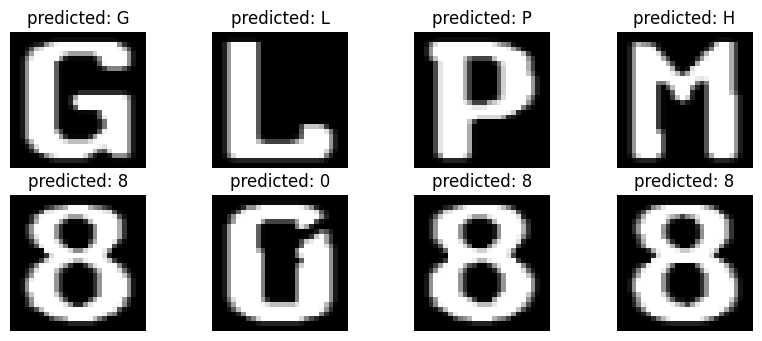

In [146]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()


0: 448x640 1 License_Plate, 1305.7ms
Speed: 2.5ms preprocess, 1305.7ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


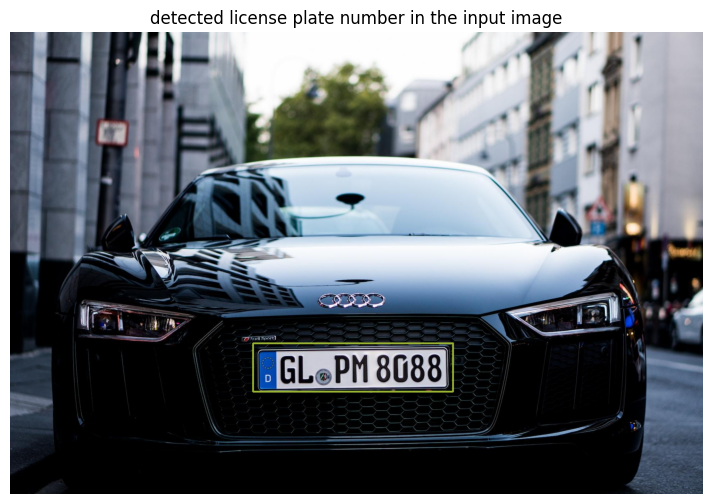

In [134]:
plate_number = show_results()
img = cv2.imread('./temp.jpg')
output_img, plate = detect_plate(img, plate_number)
display(output_img, 'detected license plate number in the input image')

In [126]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

# پوشه اصلی دیتاست
root_dataset = 'dataset'
subfolders = ['train', 'valid', 'test']

all_data = []

for split in subfolders:
    folder_path = os.path.join(root_dataset, split)
    files = os.listdir(folder_path)

    # فقط XMLهایی که فایل تصویری متناظر دارند
    xml_files = [f for f in files if f.endswith('.xml')]

    for xml_file in xml_files:
        xml_path = os.path.join(folder_path, xml_file)
        base_name = os.path.splitext(xml_file)[0]
        
        # پیدا کردن فایل تصویر متناظر (jpg یا png)
        image_path = None
        for ext in ['.jpg', '.jpeg', '.png']:
            candidate = os.path.join(folder_path, base_name + ext)
            if os.path.exists(candidate):
                image_path = candidate
                break
        
        if image_path is None:
            continue  # اگر تصویر نبود، برو سراغ بعدی

        # پارس XML و استخراج اطلاعات
        tree = ET.parse(xml_path)
        root = tree.getroot()

        for obj in root.findall('object'):
            class_name = obj.find('name').text
            bndbox = obj.find('bndbox')
            xmin = int(float(bndbox.find('xmin').text))
            ymin = int(float(bndbox.find('ymin').text))
            xmax = int(float(bndbox.find('xmax').text))
            ymax = int(float(bndbox.find('ymax').text))

            all_data.append({
                'split': split,
                'image': image_path,
                'class': class_name,
                'xmin': xmin,
                'ymin': ymin,
                'xmax': xmax,
                'ymax': ymax
            })

# ساخت دیتافریم
df = pd.DataFrame(all_data)
df.head()


split                                              image         class  \
0  train  dataset\train\0073797c-a755-4972-b76b-8ef2b31d...  LicensePlate   
1  train  dataset\train\00b42b2c-f193-4863-b92c-0245cbc8...  LicensePlate   
2  train  dataset\train\018b52e6-e9a1-42c2-8ce7-0617e8c8...  LicensePlate   
3  train  dataset\train\03273806-bb1e-48da-8c8b-a0133a90...  LicensePlate   
4  train  dataset\train\07064c2c-2aa3-4419-91a4-92916de8...  LicensePlate   

   xmin  ymin  xmax  ymax  
0   179   400   434   496  
1    93   430   147   487  
2   317   461   387   518  
3   201   390   407   456  
4   262   447   429   544

In [ ]:
print("تعداد کل نمونه‌ها در هر بخش:")
print(df['split'].value_counts())


تعداد کل نمونه‌ها در هر بخش:
train    275
valid     78
test      37
Name: split, dtype: int64


In [ ]:
# import os
# import cv2

# output_dir = 'cropped'  # فولدری که عکس‌های بریده‌شده ذخیره میشه

# # ساخت پوشه‌ها برای هر بخش (train / valid / test)
# for split in ['train', 'valid', 'test']:
#     os.makedirs(os.path.join(output_dir, split), exist_ok=True)

# # پردازش ردیف به ردیف دیتا
# for i, row in df.iterrows():
#     img_path = row['image']
#     split = row['split']
#     label = row['name'] if 'name' in row and pd.notna(row['name']) else 'plate'

#     # خواندن تصویر
#     img = cv2.imread(img_path)
#     if img is None:
#         print(f"[!] مشکل در باز کردن عکس: {img_path}")
#         continue

#     # بریدن پلاک با مختصات
#     x1, y1, x2, y2 = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
#     cropped_plate = img[y1:y2, x1:x2]

#     # مسیر ذخیره نهایی
#     filename = f"{label}_{i}.jpg"
#     save_path = os.path.join(output_dir, split, filename)

#     # ذخیره تصویر بریده‌شده
#     cv2.imwrite(save_path, cropped_plate)


In [ ]:
print(df[['image', 'class']].head(10))

                                               image         class
0  dataset\train\0073797c-a755-4972-b76b-8ef2b31d...  LicensePlate
1  dataset\train\00b42b2c-f193-4863-b92c-0245cbc8...  LicensePlate
2  dataset\train\018b52e6-e9a1-42c2-8ce7-0617e8c8...  LicensePlate
3  dataset\train\03273806-bb1e-48da-8c8b-a0133a90...  LicensePlate
4  dataset\train\07064c2c-2aa3-4419-91a4-92916de8...  LicensePlate
5  dataset\train\07bd977e-d578-49a2-b345-7cee5a4d...  LicensePlate
6  dataset\train\07f6d77a-652e-4885-8520-6d405d2f...  LicensePlate
7  dataset\train\0850c175-0b8d-47f2-801c-e29f1dbd...  LicensePlate
8  dataset\train\092c497e-623d-499d-822a-4b01c657...  LicensePlate
9  dataset\train\0b24d6ed-d32f-420d-bc18-03deece2...  LicensePlate


In [ ]:
def preprocess_plate_for_ocr(plate_img):
    # Resize to fixed size (مثل مدل‌های قبل)
    plate = cv2.resize(plate_img, (333, 75))

    # Grayscale
    gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)

    # Threshold (Otsu)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphology (erode → dilate)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    binary = cv2.erode(binary, kernel, iterations=1)
    binary = cv2.dilate(binary, kernel, iterations=1)

    # حذف نویز لبه‌ها
    binary[0:3,:] = 255
    binary[:,0:3] = 255
    binary[-3:,:] = 255
    binary[:,-3:] = 255

    # تبدیل به 3 کاناله (اختیاری اگر مدل بعدی color بخواد)
    binary_rgb = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

    return binary_rgb


In [ ]:
import os
import cv2
from tqdm import tqdm

# پوشه خروجی
output_dir = 'cropped_plates'
os.makedirs(output_dir, exist_ok=True)

# ارسال مدل به CPU فقط یک‌بار
yolo_model.to('cpu')

for i, row in tqdm(df.iterrows(), total=len(df)):
    img_path = row['image']
    split = row['split']
    label = row['class'] if 'class' in row else 'plate'

    # بارگذاری تصویر
    img = cv2.imread(img_path)
    if img is None:
        print(f"[!] خطا در باز کردن تصویر: {img_path}")
        continue

    # تشخیص پلاک با YOLO
    _, plate = detect_plate(img, text=label)

    if plate is None:
        print(f"[!] هیچ پلاکی پیدا نشد در: {img_path}")
        continue

    # ساخت پوشه split
    split_dir = os.path.join(output_dir, split)
    os.makedirs(split_dir, exist_ok=True)

    # نام‌گذاری فایل خروجی
    filename = f"{label}_{i}.jpg"
    save_path = os.path.join(split_dir, filename)

    # ذخیره تصویر کراپ‌شده پلاک
    processed_plate = preprocess_plate_for_ocr(plate)
    cv2.imwrite(save_path, processed_plate)

print("✅ تمام پلاک‌ها استخراج و ذخیره شدند.")


  0%|          | 0/390 [00:00<?, ?it/s]


0: 640x640 1 License_Plate, 2469.9ms
Speed: 4.1ms preprocess, 2469.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 1/390 [00:02<16:21,  2.52s/it]


0: 640x640 1 License_Plate, 2490.6ms
Speed: 2.6ms preprocess, 2490.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 2/390 [00:05<16:21,  2.53s/it]


0: 640x640 1 License_Plate, 2416.0ms
Speed: 5.0ms preprocess, 2416.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 3/390 [00:07<16:07,  2.50s/it]


0: 640x640 1 License_Plate, 1961.1ms
Speed: 3.9ms preprocess, 1961.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 4/390 [00:09<14:49,  2.30s/it]


0: 640x640 1 License_Plate, 2303.7ms
Speed: 4.0ms preprocess, 2303.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  1%|▏         | 5/390 [00:11<14:52,  2.32s/it]


0: 640x640 1 License_Plate, 2179.6ms
Speed: 4.7ms preprocess, 2179.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 6/390 [00:14<14:38,  2.29s/it]


0: 640x640 1 License_Plate, 2097.4ms
Speed: 3.4ms preprocess, 2097.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 7/390 [00:16<14:18,  2.24s/it]


0: 640x640 1 License_Plate, 2049.2ms
Speed: 4.8ms preprocess, 2049.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 8/390 [00:18<13:57,  2.19s/it]


0: 640x640 1 License_Plate, 2037.1ms
Speed: 5.2ms preprocess, 2037.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 9/390 [00:20<13:41,  2.16s/it]


0: 640x640 1 License_Plate, 2242.4ms
Speed: 3.2ms preprocess, 2242.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 10/390 [00:22<13:53,  2.19s/it]


0: 640x640 1 License_Plate, 2102.3ms
Speed: 3.2ms preprocess, 2102.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 11/390 [00:24<13:45,  2.18s/it]


0: 640x640 1 License_Plate, 2329.7ms
Speed: 2.7ms preprocess, 2329.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 12/390 [00:27<14:05,  2.24s/it]


0: 640x640 1 License_Plate, 2150.4ms
Speed: 4.3ms preprocess, 2150.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 13/390 [00:29<13:58,  2.22s/it]


0: 640x640 1 License_Plate, 1991.1ms
Speed: 5.5ms preprocess, 1991.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  4%|▎         | 14/390 [00:31<13:35,  2.17s/it]


0: 640x640 1 License_Plate, 1898.4ms
Speed: 4.0ms preprocess, 1898.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 15/390 [00:33<13:07,  2.10s/it]


0: 640x640 1 License_Plate, 2033.8ms
Speed: 4.7ms preprocess, 2033.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 16/390 [00:35<13:02,  2.09s/it]


0: 640x640 1 License_Plate, 2047.5ms
Speed: 5.6ms preprocess, 2047.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 17/390 [00:37<13:01,  2.09s/it]


0: 640x640 3 License_Plates, 2059.4ms
Speed: 4.6ms preprocess, 2059.4ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


  5%|▍         | 18/390 [00:39<12:59,  2.10s/it]


0: 640x640 1 License_Plate, 1971.7ms
Speed: 3.0ms preprocess, 1971.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  5%|▍         | 19/390 [00:41<12:48,  2.07s/it]


0: 640x640 1 License_Plate, 1945.4ms
Speed: 3.8ms preprocess, 1945.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 20/390 [00:43<12:36,  2.05s/it]


0: 640x640 (no detections), 1910.2ms
Speed: 3.0ms preprocess, 1910.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 21/390 [00:45<12:24,  2.02s/it]

[!] هیچ پلاکی پیدا نشد در: dataset\train\18f2e55e-0724-4eee-a28e-5d552a5aa045___20455d0e2dca458f13fbf4da5a2dc118-jpg_jpeg.rf.97a0e92dc2a0dbd91fe0a0461518bc24.jpg

0: 640x640 1 License_Plate, 1975.9ms
Speed: 5.2ms preprocess, 1975.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 22/390 [00:47<12:21,  2.02s/it]


0: 640x640 1 License_Plate, 1933.8ms
Speed: 4.7ms preprocess, 1933.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 23/390 [00:49<12:14,  2.00s/it]


0: 640x640 1 License_Plate, 2000.1ms
Speed: 5.4ms preprocess, 2000.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 24/390 [00:51<12:18,  2.02s/it]


0: 640x640 1 License_Plate, 1959.0ms
Speed: 4.0ms preprocess, 1959.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  6%|▋         | 25/390 [00:53<12:16,  2.02s/it]


0: 640x640 1 License_Plate, 1911.5ms
Speed: 3.4ms preprocess, 1911.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 26/390 [00:55<12:07,  2.00s/it]


0: 640x640 1 License_Plate, 1955.3ms
Speed: 3.6ms preprocess, 1955.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 27/390 [00:57<12:05,  2.00s/it]


0: 640x640 1 License_Plate, 1916.3ms
Speed: 3.3ms preprocess, 1916.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 28/390 [00:59<12:00,  1.99s/it]


0: 640x640 1 License_Plate, 1945.6ms
Speed: 2.7ms preprocess, 1945.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 29/390 [01:01<11:57,  1.99s/it]


0: 640x640 1 License_Plate, 1920.5ms
Speed: 3.4ms preprocess, 1920.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 30/390 [01:03<11:54,  1.98s/it]


0: 640x640 1 License_Plate, 1943.9ms
Speed: 5.2ms preprocess, 1943.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 31/390 [01:05<11:52,  1.98s/it]


0: 640x640 1 License_Plate, 2058.2ms
Speed: 4.3ms preprocess, 2058.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 32/390 [01:07<12:02,  2.02s/it]


0: 640x640 1 License_Plate, 1964.9ms
Speed: 4.6ms preprocess, 1964.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 33/390 [01:09<11:59,  2.02s/it]


0: 640x640 1 License_Plate, 2047.7ms
Speed: 3.5ms preprocess, 2047.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  9%|▊         | 34/390 [01:11<12:06,  2.04s/it]


0: 640x640 2 License_Plates, 2008.1ms
Speed: 4.4ms preprocess, 2008.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 35/390 [01:13<12:05,  2.04s/it]


0: 640x640 1 License_Plate, 1932.8ms
Speed: 3.9ms preprocess, 1932.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 36/390 [01:15<11:55,  2.02s/it]


0: 640x640 1 License_Plate, 1960.3ms
Speed: 3.9ms preprocess, 1960.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 37/390 [01:17<11:53,  2.02s/it]


0: 640x640 1 License_Plate, 1938.6ms
Speed: 3.4ms preprocess, 1938.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 10%|▉         | 38/390 [01:19<11:46,  2.01s/it]


0: 640x640 1 License_Plate, 1940.9ms
Speed: 3.4ms preprocess, 1940.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 39/390 [01:21<11:41,  2.00s/it]


0: 640x640 1 License_Plate, 1962.0ms
Speed: 3.5ms preprocess, 1962.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 40/390 [01:23<11:39,  2.00s/it]


0: 640x640 1 License_Plate, 1903.1ms
Speed: 4.2ms preprocess, 1903.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 41/390 [01:25<11:32,  1.98s/it]


0: 640x640 2 License_Plates, 1968.3ms
Speed: 3.6ms preprocess, 1968.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 42/390 [01:27<11:32,  1.99s/it]


0: 640x640 1 License_Plate, 1909.4ms
Speed: 3.8ms preprocess, 1909.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 43/390 [01:29<11:28,  1.98s/it]


0: 640x640 1 License_Plate, 1981.2ms
Speed: 3.4ms preprocess, 1981.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 11%|█▏        | 44/390 [01:31<11:29,  1.99s/it]


0: 640x640 1 License_Plate, 1943.0ms
Speed: 2.8ms preprocess, 1943.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 45/390 [01:33<11:27,  1.99s/it]


0: 640x640 1 License_Plate, 1971.1ms
Speed: 3.2ms preprocess, 1971.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 46/390 [01:35<11:27,  2.00s/it]


0: 640x640 1 License_Plate, 1984.9ms
Speed: 3.6ms preprocess, 1984.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 47/390 [01:37<11:29,  2.01s/it]


0: 640x640 1 License_Plate, 1941.5ms
Speed: 3.3ms preprocess, 1941.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 48/390 [01:39<11:23,  2.00s/it]


0: 640x640 1 License_Plate, 1913.3ms
Speed: 6.4ms preprocess, 1913.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 49/390 [01:41<11:18,  1.99s/it]


0: 640x640 1 License_Plate, 1966.2ms
Speed: 5.4ms preprocess, 1966.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 50/390 [01:43<11:18,  1.99s/it]


0: 640x640 1 License_Plate, 1899.7ms
Speed: 3.4ms preprocess, 1899.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 51/390 [01:45<11:12,  1.98s/it]


0: 640x640 1 License_Plate, 1934.2ms
Speed: 3.4ms preprocess, 1934.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 52/390 [01:47<11:11,  1.99s/it]


0: 640x640 1 License_Plate, 1920.6ms
Speed: 4.9ms preprocess, 1920.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▎        | 53/390 [01:49<11:08,  1.98s/it]


0: 640x640 1 License_Plate, 1968.5ms
Speed: 6.6ms preprocess, 1968.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 54/390 [01:51<11:09,  1.99s/it]


0: 640x640 1 License_Plate, 1907.2ms
Speed: 5.2ms preprocess, 1907.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 55/390 [01:53<11:04,  1.98s/it]


0: 640x640 1 License_Plate, 1941.3ms
Speed: 3.5ms preprocess, 1941.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 56/390 [01:55<11:01,  1.98s/it]


0: 640x640 1 License_Plate, 1928.8ms
Speed: 5.1ms preprocess, 1928.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▍        | 57/390 [01:57<10:59,  1.98s/it]


0: 640x640 1 License_Plate, 1908.2ms
Speed: 3.3ms preprocess, 1908.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▍        | 58/390 [01:59<10:55,  1.98s/it]


0: 640x640 1 License_Plate, 1921.4ms
Speed: 3.7ms preprocess, 1921.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 59/390 [02:01<10:56,  1.98s/it]


0: 640x640 1 License_Plate, 1992.6ms
Speed: 5.6ms preprocess, 1992.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 60/390 [02:03<10:59,  2.00s/it]


0: 640x640 1 License_Plate, 2042.9ms
Speed: 3.7ms preprocess, 2042.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 61/390 [02:05<11:06,  2.03s/it]


0: 640x640 1 License_Plate, 2064.5ms
Speed: 4.3ms preprocess, 2064.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 62/390 [02:07<11:12,  2.05s/it]


0: 640x640 1 License_Plate, 1982.1ms
Speed: 3.1ms preprocess, 1982.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 63/390 [02:09<11:07,  2.04s/it]


0: 640x640 1 License_Plate, 1912.9ms
Speed: 6.0ms preprocess, 1912.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▋        | 64/390 [02:11<10:56,  2.01s/it]


0: 640x640 2 License_Plates, 1942.1ms
Speed: 5.1ms preprocess, 1942.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 65/390 [02:13<10:51,  2.01s/it]


0: 640x640 1 License_Plate, 1972.4ms
Speed: 3.3ms preprocess, 1972.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 66/390 [02:15<10:52,  2.01s/it]


0: 640x640 1 License_Plate, 1919.1ms
Speed: 3.4ms preprocess, 1919.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 67/390 [02:17<10:45,  2.00s/it]


0: 640x640 1 License_Plate, 1936.6ms
Speed: 2.9ms preprocess, 1936.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 68/390 [02:19<10:40,  1.99s/it]


0: 640x640 1 License_Plate, 1916.3ms
Speed: 2.6ms preprocess, 1916.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 69/390 [02:21<10:34,  1.98s/it]


0: 640x640 1 License_Plate, 1950.8ms
Speed: 3.4ms preprocess, 1950.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 70/390 [02:23<10:34,  1.98s/it]


0: 640x640 1 License_Plate, 1917.4ms
Speed: 3.6ms preprocess, 1917.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 71/390 [02:25<10:32,  1.98s/it]


0: 640x640 1 License_Plate, 1941.6ms
Speed: 3.3ms preprocess, 1941.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 72/390 [02:27<10:29,  1.98s/it]


0: 640x640 1 License_Plate, 1909.6ms
Speed: 5.9ms preprocess, 1909.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▊        | 73/390 [02:29<10:26,  1.98s/it]


0: 640x640 (no detections), 1946.3ms
Speed: 3.3ms preprocess, 1946.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 74/390 [02:31<10:26,  1.98s/it]

[!] هیچ پلاکی پیدا نشد در: dataset\train\60842fa7-0a2e-4407-b41c-933d93bdbb35___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_nissan-terrano-red-rear_jpg.rf.0ade063e15bf9e6da0010fde9661505a.jpg

0: 640x640 1 License_Plate, 1895.3ms
Speed: 3.1ms preprocess, 1895.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 75/390 [02:33<10:19,  1.97s/it]


0: 640x640 1 License_Plate, 1949.8ms
Speed: 3.6ms preprocess, 1949.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 76/390 [02:35<10:20,  1.98s/it]


0: 640x640 1 License_Plate, 1914.0ms
Speed: 3.7ms preprocess, 1914.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 77/390 [02:37<10:16,  1.97s/it]


0: 640x640 1 License_Plate, 2020.9ms
Speed: 5.0ms preprocess, 2020.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 78/390 [02:39<10:24,  2.00s/it]


0: 640x640 1 License_Plate, 1962.4ms
Speed: 4.7ms preprocess, 1962.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 79/390 [02:41<10:22,  2.00s/it]


0: 640x640 1 License_Plate, 1986.5ms
Speed: 3.8ms preprocess, 1986.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 80/390 [02:43<10:25,  2.02s/it]


0: 640x640 1 License_Plate, 2073.7ms
Speed: 4.1ms preprocess, 2073.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 81/390 [02:45<10:31,  2.04s/it]


0: 640x640 1 License_Plate, 2024.0ms
Speed: 5.5ms preprocess, 2024.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 82/390 [02:47<10:33,  2.06s/it]


0: 640x640 1 License_Plate, 2063.6ms
Speed: 3.3ms preprocess, 2063.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 21%|██▏       | 83/390 [02:49<10:35,  2.07s/it]


0: 640x640 1 License_Plate, 2080.9ms
Speed: 5.3ms preprocess, 2080.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 84/390 [02:51<10:38,  2.09s/it]


0: 640x640 1 License_Plate, 2071.4ms
Speed: 5.2ms preprocess, 2071.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 85/390 [02:54<10:38,  2.09s/it]


0: 640x640 1 License_Plate, 2089.9ms
Speed: 4.7ms preprocess, 2089.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 86/390 [02:56<10:39,  2.11s/it]


0: 640x640 1 License_Plate, 2100.6ms
Speed: 2.9ms preprocess, 2100.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 87/390 [02:58<10:41,  2.12s/it]


0: 640x640 1 License_Plate, 2062.9ms
Speed: 4.8ms preprocess, 2062.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 88/390 [03:00<10:38,  2.11s/it]


0: 640x640 1 License_Plate, 2150.5ms
Speed: 3.5ms preprocess, 2150.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 89/390 [03:02<10:43,  2.14s/it]


0: 640x640 1 License_Plate, 2053.0ms
Speed: 3.3ms preprocess, 2053.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 90/390 [03:04<10:37,  2.13s/it]


0: 640x640 (no detections), 2054.7ms
Speed: 4.2ms preprocess, 2054.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 91/390 [03:06<10:33,  2.12s/it]

[!] هیچ پلاکی پیدا نشد در: dataset\train\730a2f83-cd53-4943-8922-af9d4fcad415___new_2_jpg.rf.a3b647a1679f9db87e8df61d6bde2bba.jpg

0: 640x640 1 License_Plate, 1999.8ms
Speed: 4.1ms preprocess, 1999.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▎       | 92/390 [03:08<10:24,  2.10s/it]


0: 640x640 1 License_Plate, 1959.7ms
Speed: 4.8ms preprocess, 1959.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 93/390 [03:10<10:13,  2.07s/it]


0: 640x640 1 License_Plate, 1941.4ms
Speed: 4.5ms preprocess, 1941.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 94/390 [03:12<10:03,  2.04s/it]


0: 640x640 1 License_Plate, 1989.7ms
Speed: 3.1ms preprocess, 1989.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 95/390 [03:14<10:00,  2.04s/it]


0: 640x640 1 License_Plate, 1934.7ms
Speed: 2.7ms preprocess, 1934.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 96/390 [03:16<09:53,  2.02s/it]


0: 640x640 1 License_Plate, 2031.7ms
Speed: 3.6ms preprocess, 2031.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 97/390 [03:18<09:56,  2.03s/it]


0: 640x640 1 License_Plate, 1949.7ms
Speed: 3.5ms preprocess, 1949.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 98/390 [03:20<09:51,  2.03s/it]


0: 640x640 1 License_Plate, 1976.4ms
Speed: 4.1ms preprocess, 1976.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 99/390 [03:22<09:48,  2.02s/it]


0: 640x640 1 License_Plate, 1979.1ms
Speed: 3.2ms preprocess, 1979.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 100/390 [03:24<09:45,  2.02s/it]


0: 640x640 1 License_Plate, 1968.4ms
Speed: 5.2ms preprocess, 1968.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 101/390 [03:26<09:45,  2.02s/it]


0: 640x640 1 License_Plate, 1929.2ms
Speed: 4.1ms preprocess, 1929.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 102/390 [03:28<09:38,  2.01s/it]


0: 640x640 1 License_Plate, 1945.4ms
Speed: 3.8ms preprocess, 1945.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▋       | 103/390 [03:30<09:35,  2.01s/it]


0: 640x640 1 License_Plate, 1968.7ms
Speed: 3.3ms preprocess, 1968.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 104/390 [03:32<09:33,  2.00s/it]


0: 640x640 1 License_Plate, 2018.9ms
Speed: 3.3ms preprocess, 2018.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 105/390 [03:34<09:35,  2.02s/it]


0: 640x640 3 License_Plates, 1993.3ms
Speed: 3.5ms preprocess, 1993.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 106/390 [03:37<09:34,  2.02s/it]


0: 640x640 1 License_Plate, 1953.1ms
Speed: 3.4ms preprocess, 1953.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 107/390 [03:39<09:29,  2.01s/it]


0: 640x640 1 License_Plate, 2134.6ms
Speed: 6.7ms preprocess, 2134.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 108/390 [03:41<09:41,  2.06s/it]


0: 640x640 1 License_Plate, 1952.5ms
Speed: 3.4ms preprocess, 1952.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 109/390 [03:43<09:33,  2.04s/it]


0: 640x640 1 License_Plate, 2000.7ms
Speed: 3.2ms preprocess, 2000.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 110/390 [03:45<09:31,  2.04s/it]


0: 640x640 1 License_Plate, 2000.7ms
Speed: 4.2ms preprocess, 2000.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 111/390 [03:47<09:29,  2.04s/it]


0: 640x640 1 License_Plate, 2006.9ms
Speed: 4.7ms preprocess, 2006.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▊       | 112/390 [03:49<09:28,  2.05s/it]


0: 640x640 1 License_Plate, 2067.6ms
Speed: 3.4ms preprocess, 2067.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 113/390 [03:51<09:31,  2.06s/it]


0: 640x640 1 License_Plate, 2035.5ms
Speed: 4.4ms preprocess, 2035.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 114/390 [03:53<09:32,  2.07s/it]


0: 640x640 1 License_Plate, 1986.8ms
Speed: 3.0ms preprocess, 1986.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 115/390 [03:55<09:26,  2.06s/it]


0: 640x640 1 License_Plate, 2055.3ms
Speed: 3.4ms preprocess, 2055.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 116/390 [03:57<09:26,  2.07s/it]


0: 640x640 1 License_Plate, 1962.2ms
Speed: 2.8ms preprocess, 1962.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 117/390 [03:59<09:18,  2.05s/it]


0: 640x640 1 License_Plate, 2016.0ms
Speed: 4.2ms preprocess, 2016.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 118/390 [04:01<09:20,  2.06s/it]


0: 640x640 1 License_Plate, 2088.3ms
Speed: 3.3ms preprocess, 2088.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 119/390 [04:03<09:25,  2.08s/it]


0: 640x640 1 License_Plate, 1966.5ms
Speed: 3.2ms preprocess, 1966.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 120/390 [04:05<09:16,  2.06s/it]


0: 640x640 1 License_Plate, 1922.3ms
Speed: 3.9ms preprocess, 1922.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 121/390 [04:07<09:06,  2.03s/it]


0: 640x640 1 License_Plate, 1973.1ms
Speed: 3.9ms preprocess, 1973.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 31%|███▏      | 122/390 [04:09<09:03,  2.03s/it]


0: 640x640 1 License_Plate, 1926.0ms
Speed: 4.5ms preprocess, 1926.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 123/390 [04:11<08:56,  2.01s/it]


0: 640x640 (no detections), 1991.6ms
Speed: 3.4ms preprocess, 1991.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 124/390 [04:13<08:57,  2.02s/it]

[!] هیچ پلاکی پیدا نشد در: dataset\train\aea95aa0-a000-4103-945d-c173383bd646___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Nissan-Terrano-11_jpg.rf.af606349afa1baac85868c9c137361e1.jpg

0: 640x640 1 License_Plate, 1923.5ms
Speed: 3.0ms preprocess, 1923.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 125/390 [04:15<08:50,  2.00s/it]


0: 640x640 1 License_Plate, 2002.6ms
Speed: 4.4ms preprocess, 2002.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 126/390 [04:17<08:52,  2.02s/it]


0: 640x640 1 License_Plate, 1941.5ms
Speed: 3.4ms preprocess, 1941.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 127/390 [04:19<08:47,  2.01s/it]


0: 640x640 1 License_Plate, 1956.0ms
Speed: 3.4ms preprocess, 1956.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 128/390 [04:21<08:44,  2.00s/it]


0: 640x640 (no detections), 1942.3ms
Speed: 3.8ms preprocess, 1942.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 129/390 [04:23<08:41,  2.00s/it]

[!] هیچ پلاکی پیدا نشد در: dataset\train\b176b317-68a9-4c38-ac39-55e5244c9b9c___60653-jpg_jpeg.rf.c65fe98ef2271b86a7cf16ca81c9e7d4.jpg

0: 640x640 1 License_Plate, 1956.9ms
Speed: 4.5ms preprocess, 1956.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 130/390 [04:25<08:39,  2.00s/it]


0: 640x640 1 License_Plate, 2011.7ms
Speed: 3.6ms preprocess, 2011.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▎      | 131/390 [04:27<08:41,  2.01s/it]


0: 640x640 1 License_Plate, 1945.5ms
Speed: 3.2ms preprocess, 1945.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 132/390 [04:29<08:36,  2.00s/it]


0: 640x640 1 License_Plate, 2036.2ms
Speed: 3.5ms preprocess, 2036.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 133/390 [04:31<08:39,  2.02s/it]


0: 640x640 1 License_Plate, 2022.1ms
Speed: 4.5ms preprocess, 2022.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 134/390 [04:34<08:41,  2.04s/it]


0: 640x640 1 License_Plate, 2019.9ms
Speed: 4.8ms preprocess, 2019.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 135/390 [04:36<08:42,  2.05s/it]


0: 640x640 1 License_Plate, 2001.5ms
Speed: 3.6ms preprocess, 2001.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 136/390 [04:38<08:39,  2.05s/it]


0: 640x640 1 License_Plate, 1970.3ms
Speed: 4.4ms preprocess, 1970.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 137/390 [04:40<08:34,  2.03s/it]


0: 640x640 2 License_Plates, 2000.0ms
Speed: 5.5ms preprocess, 2000.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 138/390 [04:42<08:32,  2.04s/it]


0: 640x640 1 License_Plate, 2018.0ms
Speed: 5.3ms preprocess, 2018.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 139/390 [04:44<08:32,  2.04s/it]


0: 640x640 2 License_Plates, 1973.8ms
Speed: 3.7ms preprocess, 1973.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 140/390 [04:46<08:28,  2.03s/it]


0: 640x640 1 License_Plate, 1978.6ms
Speed: 3.0ms preprocess, 1978.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 141/390 [04:48<08:24,  2.03s/it]


0: 640x640 1 License_Plate, 1999.9ms
Speed: 3.5ms preprocess, 1999.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▋      | 142/390 [04:50<08:23,  2.03s/it]


0: 640x640 1 License_Plate, 1971.6ms
Speed: 4.0ms preprocess, 1971.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 143/390 [04:52<08:19,  2.02s/it]


0: 640x640 1 License_Plate, 2124.9ms
Speed: 3.8ms preprocess, 2124.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 144/390 [04:54<08:28,  2.07s/it]


0: 640x640 1 License_Plate, 2092.7ms
Speed: 3.1ms preprocess, 2092.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 145/390 [04:56<08:31,  2.09s/it]


0: 640x640 1 License_Plate, 2170.4ms
Speed: 3.4ms preprocess, 2170.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 146/390 [04:58<08:37,  2.12s/it]


0: 640x640 1 License_Plate, 2079.8ms
Speed: 4.9ms preprocess, 2079.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 147/390 [05:00<08:36,  2.13s/it]


0: 640x640 1 License_Plate, 2141.7ms
Speed: 4.8ms preprocess, 2141.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 148/390 [05:03<08:38,  2.14s/it]


0: 640x640 1 License_Plate, 2048.2ms
Speed: 3.2ms preprocess, 2048.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 149/390 [05:05<08:32,  2.13s/it]


0: 640x640 1 License_Plate, 1991.9ms
Speed: 3.2ms preprocess, 1991.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 150/390 [05:07<08:23,  2.10s/it]


0: 640x640 1 License_Plate, 1978.4ms
Speed: 4.5ms preprocess, 1978.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▊      | 151/390 [05:09<08:17,  2.08s/it]


0: 640x640 (no detections), 2011.0ms
Speed: 3.3ms preprocess, 2011.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 152/390 [05:11<08:13,  2.07s/it]

[!] هیچ پلاکی پیدا نشد در: dataset\train\c795950c-766a-4a2e-9636-62d663d6f06b___62bf1edb36141f114521ec4bb4175579-jpg_jpeg.rf.13391c2545f96f2d407bdb2dc8fbd5d3.jpg

0: 640x640 1 License_Plate, 1981.9ms
Speed: 4.1ms preprocess, 1981.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 153/390 [05:13<08:07,  2.06s/it]


0: 640x640 1 License_Plate, 1990.4ms
Speed: 4.4ms preprocess, 1990.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 154/390 [05:15<08:03,  2.05s/it]


0: 640x640 1 License_Plate, 1986.0ms
Speed: 4.8ms preprocess, 1986.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 155/390 [05:17<08:01,  2.05s/it]


0: 640x640 1 License_Plate, 1976.2ms
Speed: 6.3ms preprocess, 1976.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 156/390 [05:19<07:57,  2.04s/it]


0: 640x640 1 License_Plate, 2024.5ms
Speed: 3.6ms preprocess, 2024.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 157/390 [05:21<07:58,  2.05s/it]


0: 640x640 1 License_Plate, 2026.7ms
Speed: 3.7ms preprocess, 2026.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 158/390 [05:23<07:57,  2.06s/it]


0: 640x640 1 License_Plate, 2142.0ms
Speed: 4.0ms preprocess, 2142.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 159/390 [05:25<08:04,  2.10s/it]


0: 640x640 1 License_Plate, 2061.7ms
Speed: 4.6ms preprocess, 2061.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 160/390 [05:27<08:02,  2.10s/it]


0: 640x640 1 License_Plate, 2122.3ms
Speed: 3.6ms preprocess, 2122.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 41%|████▏     | 161/390 [05:30<08:04,  2.12s/it]


0: 640x640 1 License_Plate, 2186.7ms
Speed: 3.5ms preprocess, 2186.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 162/390 [05:32<08:09,  2.15s/it]


0: 640x640 1 License_Plate, 2188.7ms
Speed: 5.1ms preprocess, 2188.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 163/390 [05:34<08:12,  2.17s/it]


0: 640x640 1 License_Plate, 2017.2ms
Speed: 4.4ms preprocess, 2017.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 164/390 [05:36<08:02,  2.14s/it]


0: 640x640 1 License_Plate, 2001.3ms
Speed: 4.5ms preprocess, 2001.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 165/390 [05:38<07:54,  2.11s/it]


0: 640x640 1 License_Plate, 2008.3ms
Speed: 4.9ms preprocess, 2008.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 166/390 [05:40<07:49,  2.09s/it]


0: 640x640 1 License_Plate, 1980.5ms
Speed: 2.9ms preprocess, 1980.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 167/390 [05:42<07:41,  2.07s/it]


0: 640x640 1 License_Plate, 2091.6ms
Speed: 4.8ms preprocess, 2091.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 168/390 [05:44<07:43,  2.09s/it]


0: 640x640 1 License_Plate, 2095.2ms
Speed: 3.9ms preprocess, 2095.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 169/390 [05:46<07:44,  2.10s/it]


0: 640x640 1 License_Plate, 2119.1ms
Speed: 4.0ms preprocess, 2119.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▎     | 170/390 [05:49<07:46,  2.12s/it]


0: 640x640 1 License_Plate, 2092.2ms
Speed: 3.7ms preprocess, 2092.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 171/390 [05:51<07:44,  2.12s/it]


0: 640x640 1 License_Plate, 2120.7ms
Speed: 3.4ms preprocess, 2120.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 172/390 [05:53<07:45,  2.13s/it]


0: 640x640 1 License_Plate, 2120.3ms
Speed: 5.8ms preprocess, 2120.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 173/390 [05:55<07:45,  2.14s/it]


0: 640x640 1 License_Plate, 2072.4ms
Speed: 3.3ms preprocess, 2072.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 174/390 [05:57<07:40,  2.13s/it]


0: 640x640 1 License_Plate, 1987.1ms
Speed: 4.1ms preprocess, 1987.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 175/390 [05:59<07:31,  2.10s/it]


0: 640x640 1 License_Plate, 1924.5ms
Speed: 4.1ms preprocess, 1924.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 176/390 [06:01<07:22,  2.07s/it]


0: 640x640 1 License_Plate, 2014.3ms
Speed: 3.8ms preprocess, 2014.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 177/390 [06:03<07:19,  2.07s/it]


0: 640x640 1 License_Plate, 1995.6ms
Speed: 5.0ms preprocess, 1995.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 178/390 [06:05<07:15,  2.06s/it]


0: 640x640 1 License_Plate, 2008.2ms
Speed: 4.9ms preprocess, 2008.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 179/390 [06:07<07:13,  2.05s/it]


0: 640x640 1 License_Plate, 1989.3ms
Speed: 4.6ms preprocess, 1989.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 180/390 [06:09<07:09,  2.05s/it]


0: 640x640 2 License_Plates, 1988.3ms
Speed: 4.6ms preprocess, 1988.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▋     | 181/390 [06:11<07:08,  2.05s/it]


0: 640x640 1 License_Plate, 2039.2ms
Speed: 4.0ms preprocess, 2039.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 182/390 [06:14<07:09,  2.07s/it]


0: 640x640 1 License_Plate, 1966.5ms
Speed: 6.3ms preprocess, 1966.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 183/390 [06:16<07:05,  2.05s/it]


0: 640x640 1 License_Plate, 1964.6ms
Speed: 4.1ms preprocess, 1964.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 184/390 [06:18<07:00,  2.04s/it]


0: 640x640 1 License_Plate, 1969.6ms
Speed: 3.7ms preprocess, 1969.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 185/390 [06:20<06:56,  2.03s/it]


0: 640x640 1 License_Plate, 2017.6ms
Speed: 3.8ms preprocess, 2017.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 186/390 [06:22<06:55,  2.04s/it]


0: 640x640 1 License_Plate, 2009.1ms
Speed: 3.0ms preprocess, 2009.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 187/390 [06:24<06:54,  2.04s/it]


0: 640x640 1 License_Plate, 2028.5ms
Speed: 3.1ms preprocess, 2028.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 188/390 [06:26<06:54,  2.05s/it]


0: 640x640 2 License_Plates, 2099.4ms
Speed: 3.5ms preprocess, 2099.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 189/390 [06:28<06:57,  2.08s/it]


0: 640x640 1 License_Plate, 1980.3ms
Speed: 3.1ms preprocess, 1980.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▊     | 190/390 [06:30<06:51,  2.06s/it]


0: 640x640 1 License_Plate, 1988.4ms
Speed: 3.3ms preprocess, 1988.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 191/390 [06:32<06:47,  2.05s/it]


0: 640x640 1 License_Plate, 2079.1ms
Speed: 6.3ms preprocess, 2079.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 192/390 [06:34<06:51,  2.08s/it]


0: 640x640 1 License_Plate, 2025.3ms
Speed: 3.7ms preprocess, 2025.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 193/390 [06:36<06:48,  2.07s/it]


0: 640x640 1 License_Plate, 1980.1ms
Speed: 3.4ms preprocess, 1980.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 50%|████▉     | 194/390 [06:38<06:43,  2.06s/it]


0: 640x640 1 License_Plate, 1949.9ms
Speed: 3.1ms preprocess, 1949.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 195/390 [06:40<06:37,  2.04s/it]


0: 640x640 1 License_Plate, 1983.7ms
Speed: 4.1ms preprocess, 1983.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 196/390 [06:42<06:34,  2.03s/it]


0: 640x640 1 License_Plate, 2093.9ms
Speed: 5.6ms preprocess, 2093.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 197/390 [06:44<06:38,  2.06s/it]


0: 640x640 1 License_Plate, 2019.5ms
Speed: 5.1ms preprocess, 2019.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 198/390 [06:46<06:36,  2.06s/it]


0: 640x640 1 License_Plate, 2080.4ms
Speed: 5.2ms preprocess, 2080.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 199/390 [06:48<06:38,  2.09s/it]


0: 640x640 1 License_Plate, 2055.7ms
Speed: 3.7ms preprocess, 2055.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████▏    | 200/390 [06:51<06:36,  2.09s/it]


0: 640x640 1 License_Plate, 2021.8ms
Speed: 4.0ms preprocess, 2021.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 201/390 [06:53<06:34,  2.09s/it]


0: 640x640 1 License_Plate, 2104.3ms
Speed: 3.4ms preprocess, 2104.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 202/390 [06:55<06:35,  2.10s/it]


0: 640x640 1 License_Plate, 1971.6ms
Speed: 3.0ms preprocess, 1971.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 203/390 [06:57<06:28,  2.08s/it]


0: 640x640 1 License_Plate, 1965.0ms
Speed: 3.7ms preprocess, 1965.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 204/390 [06:59<06:22,  2.05s/it]


0: 640x640 1 License_Plate, 1975.6ms
Speed: 3.8ms preprocess, 1975.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 205/390 [07:01<06:17,  2.04s/it]


0: 640x640 1 License_Plate, 2009.5ms
Speed: 3.5ms preprocess, 2009.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 206/390 [07:03<06:16,  2.04s/it]


0: 640x640 1 License_Plate, 2162.7ms
Speed: 4.0ms preprocess, 2162.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 207/390 [07:05<06:23,  2.09s/it]


0: 640x640 1 License_Plate, 2144.7ms
Speed: 4.1ms preprocess, 2144.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 208/390 [07:07<06:26,  2.12s/it]


0: 640x640 1 License_Plate, 1964.9ms
Speed: 4.4ms preprocess, 1964.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▎    | 209/390 [07:09<06:17,  2.09s/it]


0: 640x640 1 License_Plate, 1979.9ms
Speed: 2.6ms preprocess, 1979.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 210/390 [07:11<06:11,  2.06s/it]


0: 640x640 1 License_Plate, 2116.8ms
Speed: 3.6ms preprocess, 2116.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 211/390 [07:13<06:14,  2.09s/it]


0: 640x640 2 License_Plates, 2725.5ms
Speed: 3.7ms preprocess, 2725.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 212/390 [07:16<06:48,  2.29s/it]


0: 640x640 1 License_Plate, 2714.6ms
Speed: 6.4ms preprocess, 2714.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▍    | 213/390 [07:19<07:11,  2.44s/it]


0: 640x640 1 License_Plate, 2711.0ms
Speed: 4.5ms preprocess, 2711.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▍    | 214/390 [07:22<07:25,  2.53s/it]


0: 640x640 1 License_Plate, 2715.3ms
Speed: 3.2ms preprocess, 2715.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 215/390 [07:25<07:35,  2.60s/it]


0: 640x640 1 License_Plate, 2897.2ms
Speed: 5.2ms preprocess, 2897.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 216/390 [07:27<07:50,  2.70s/it]


0: 640x640 1 License_Plate, 2620.7ms
Speed: 3.3ms preprocess, 2620.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 217/390 [07:30<07:46,  2.69s/it]


0: 640x640 1 License_Plate, 2091.2ms
Speed: 4.6ms preprocess, 2091.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 218/390 [07:32<07:14,  2.53s/it]


0: 640x640 1 License_Plate, 2133.5ms
Speed: 3.4ms preprocess, 2133.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 219/390 [07:34<06:54,  2.42s/it]


0: 640x640 2 License_Plates, 2079.3ms
Speed: 3.6ms preprocess, 2079.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▋    | 220/390 [07:37<06:36,  2.33s/it]


0: 640x640 1 License_Plate, 2014.2ms
Speed: 4.0ms preprocess, 2014.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 221/390 [07:39<06:19,  2.25s/it]


0: 640x640 2 License_Plates, 2015.6ms
Speed: 3.9ms preprocess, 2015.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 222/390 [07:41<06:08,  2.19s/it]


0: 640x640 1 License_Plate, 1922.2ms
Speed: 3.7ms preprocess, 1922.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 223/390 [07:43<05:54,  2.12s/it]


0: 640x640 1 License_Plate, 1953.9ms
Speed: 4.8ms preprocess, 1953.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 224/390 [07:45<05:45,  2.08s/it]


0: 640x640 1 License_Plate, 2208.2ms
Speed: 5.0ms preprocess, 2208.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 225/390 [07:47<05:51,  2.13s/it]


0: 640x640 1 License_Plate, 2399.7ms
Speed: 6.4ms preprocess, 2399.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 226/390 [07:49<06:05,  2.23s/it]


0: 640x640 1 License_Plate, 2009.2ms
Speed: 5.2ms preprocess, 2009.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 227/390 [07:51<05:54,  2.17s/it]


0: 640x640 2 License_Plates, 2038.6ms
Speed: 6.0ms preprocess, 2038.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 228/390 [07:53<05:47,  2.15s/it]


0: 640x640 1 License_Plate, 2052.8ms
Speed: 3.4ms preprocess, 2052.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▊    | 229/390 [07:56<05:42,  2.13s/it]


0: 640x640 1 License_Plate, 2036.0ms
Speed: 4.2ms preprocess, 2036.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 230/390 [07:58<05:37,  2.11s/it]


0: 640x640 1 License_Plate, 2215.0ms
Speed: 4.1ms preprocess, 2215.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 231/390 [08:00<05:42,  2.15s/it]


0: 640x640 1 License_Plate, 2261.1ms
Speed: 2.8ms preprocess, 2261.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 232/390 [08:02<05:46,  2.20s/it]


0: 640x640 1 License_Plate, 2140.9ms
Speed: 3.2ms preprocess, 2140.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 233/390 [08:04<05:43,  2.19s/it]


0: 640x640 1 License_Plate, 2265.8ms
Speed: 3.8ms preprocess, 2265.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 234/390 [08:07<05:47,  2.23s/it]


0: 640x640 1 License_Plate, 2118.1ms
Speed: 3.9ms preprocess, 2118.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 235/390 [08:09<05:41,  2.21s/it]


0: 640x640 (no detections), 2062.5ms
Speed: 4.1ms preprocess, 2062.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 236/390 [08:11<05:34,  2.17s/it]

[!] هیچ پلاکی پیدا نشد در: dataset\train\cbd81ff4-fc2a-4cd5-bed6-0fef4c456caa___226616d1495986750-zoomcar-review-mahindra-scorpio-s4-09-pamban-jpg_jpeg.rf.d6714ff1761cfb29b32dda9ed694db40.jpg

0: 640x640 1 License_Plate, 2025.5ms
Speed: 3.6ms preprocess, 2025.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 237/390 [08:13<05:27,  2.14s/it]


0: 640x640 1 License_Plate, 1992.1ms
Speed: 3.7ms preprocess, 1992.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 238/390 [08:15<05:20,  2.11s/it]


0: 640x640 1 License_Plate, 1932.1ms
Speed: 3.3ms preprocess, 1932.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████▏   | 239/390 [08:17<05:12,  2.07s/it]


0: 640x640 1 License_Plate, 1945.6ms
Speed: 5.1ms preprocess, 1945.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 240/390 [08:19<05:06,  2.04s/it]


0: 640x640 1 License_Plate, 1970.7ms
Speed: 3.5ms preprocess, 1970.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 241/390 [08:21<05:02,  2.03s/it]


0: 640x640 1 License_Plate, 1964.8ms
Speed: 4.5ms preprocess, 1964.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 242/390 [08:23<04:59,  2.02s/it]


0: 640x640 1 License_Plate, 1935.0ms
Speed: 3.5ms preprocess, 1935.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 243/390 [08:25<04:54,  2.01s/it]


0: 640x640 1 License_Plate, 1972.3ms
Speed: 3.6ms preprocess, 1972.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 244/390 [08:27<04:53,  2.01s/it]


0: 640x640 1 License_Plate, 1945.5ms
Speed: 3.1ms preprocess, 1945.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 245/390 [08:29<04:49,  2.00s/it]


0: 640x640 1 License_Plate, 1950.9ms
Speed: 3.3ms preprocess, 1950.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 246/390 [08:31<04:47,  2.00s/it]


0: 640x640 1 License_Plate, 1967.2ms
Speed: 3.6ms preprocess, 1967.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 247/390 [08:33<04:45,  2.00s/it]


0: 640x640 (no detections), 1954.6ms
Speed: 3.3ms preprocess, 1954.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▎   | 248/390 [08:35<04:43,  2.00s/it]

[!] هیچ پلاکی پیدا نشد در: dataset\train\dfedf2ad-6596-48d4-a7f6-171e55c8f637___1160575d1383218860-high-security-registration-plates-hsrp-india-wp_20131030_16_01_22_pro-jpg_jpeg.rf.15936aa12f74eb3b8ed962b60cce15e4.jpg

0: 640x640 1 License_Plate, 1930.0ms
Speed: 4.4ms preprocess, 1930.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 249/390 [08:37<04:40,  1.99s/it]


0: 640x640 2 License_Plates, 1981.6ms
Speed: 4.4ms preprocess, 1981.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 250/390 [08:39<04:39,  2.00s/it]


0: 640x640 1 License_Plate, 1911.1ms
Speed: 3.4ms preprocess, 1911.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 251/390 [08:41<04:35,  1.98s/it]


0: 640x640 1 License_Plate, 1922.1ms
Speed: 3.7ms preprocess, 1922.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▍   | 252/390 [08:43<04:32,  1.98s/it]


0: 640x640 1 License_Plate, 1894.8ms
Speed: 2.5ms preprocess, 1894.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▍   | 253/390 [08:45<04:28,  1.96s/it]


0: 640x640 1 License_Plate, 1856.0ms
Speed: 2.6ms preprocess, 1856.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 254/390 [08:47<04:23,  1.94s/it]


0: 640x640 1 License_Plate, 1863.0ms
Speed: 2.9ms preprocess, 1863.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 255/390 [08:49<04:20,  1.93s/it]


0: 640x640 2 License_Plates, 1862.3ms
Speed: 2.9ms preprocess, 1862.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 256/390 [08:50<04:17,  1.92s/it]


0: 640x640 1 License_Plate, 1948.2ms
Speed: 2.6ms preprocess, 1948.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 257/390 [08:52<04:17,  1.94s/it]


0: 640x640 1 License_Plate, 1966.1ms
Speed: 2.5ms preprocess, 1966.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 258/390 [08:54<04:18,  1.96s/it]


0: 640x640 1 License_Plate, 1867.7ms
Speed: 3.4ms preprocess, 1867.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▋   | 259/390 [08:56<04:14,  1.94s/it]


0: 640x640 1 License_Plate, 1862.8ms
Speed: 2.3ms preprocess, 1862.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 260/390 [08:58<04:10,  1.93s/it]


0: 640x640 1 License_Plate, 1869.9ms
Speed: 2.3ms preprocess, 1869.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 261/390 [09:00<04:07,  1.92s/it]


0: 640x640 1 License_Plate, 1897.5ms
Speed: 3.0ms preprocess, 1897.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 262/390 [09:02<04:06,  1.93s/it]


0: 640x640 1 License_Plate, 1855.7ms
Speed: 2.7ms preprocess, 1855.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 263/390 [09:04<04:03,  1.92s/it]


0: 640x640 1 License_Plate, 1871.4ms
Speed: 2.4ms preprocess, 1871.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 264/390 [09:06<04:00,  1.91s/it]


0: 640x640 2 License_Plates, 1952.0ms
Speed: 2.3ms preprocess, 1952.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 265/390 [09:08<04:01,  1.93s/it]


0: 640x640 1 License_Plate, 1915.2ms
Speed: 2.5ms preprocess, 1915.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 266/390 [09:10<04:00,  1.94s/it]


0: 640x640 1 License_Plate, 1907.4ms
Speed: 2.4ms preprocess, 1907.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 267/390 [09:12<03:58,  1.94s/it]


0: 640x640 1 License_Plate, 1901.1ms
Speed: 2.3ms preprocess, 1901.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▊   | 268/390 [09:14<03:56,  1.94s/it]


0: 640x640 2 License_Plates, 1870.8ms
Speed: 2.4ms preprocess, 1870.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 269/390 [09:16<03:53,  1.93s/it]


0: 640x640 1 License_Plate, 1930.5ms
Speed: 2.7ms preprocess, 1930.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 270/390 [09:18<03:52,  1.94s/it]


0: 640x640 2 License_Plates, 1914.5ms
Speed: 2.6ms preprocess, 1914.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 271/390 [09:19<03:50,  1.94s/it]


0: 640x640 1 License_Plate, 1877.0ms
Speed: 3.1ms preprocess, 1877.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 272/390 [09:21<03:47,  1.93s/it]


0: 640x640 1 License_Plate, 1886.5ms
Speed: 2.3ms preprocess, 1886.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 273/390 [09:23<03:45,  1.93s/it]


0: 640x640 1 License_Plate, 1836.0ms
Speed: 3.2ms preprocess, 1836.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 274/390 [09:25<03:41,  1.91s/it]


0: 640x640 1 License_Plate, 1864.3ms
Speed: 2.3ms preprocess, 1864.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 275/390 [09:27<03:39,  1.91s/it]


0: 640x640 1 License_Plate, 1834.8ms
Speed: 3.3ms preprocess, 1834.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 276/390 [09:29<03:36,  1.90s/it]


0: 640x640 1 License_Plate, 1855.0ms
Speed: 2.7ms preprocess, 1855.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 277/390 [09:31<03:33,  1.89s/it]


0: 640x640 1 License_Plate, 1866.9ms
Speed: 2.7ms preprocess, 1866.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████▏  | 278/390 [09:33<03:32,  1.89s/it]


0: 640x640 2 License_Plates, 1877.2ms
Speed: 2.4ms preprocess, 1877.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 279/390 [09:35<03:30,  1.90s/it]


0: 640x640 1 License_Plate, 1886.1ms
Speed: 3.7ms preprocess, 1886.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 280/390 [09:37<03:29,  1.90s/it]


0: 640x640 1 License_Plate, 1843.3ms
Speed: 2.2ms preprocess, 1843.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 281/390 [09:38<03:26,  1.90s/it]


0: 640x640 1 License_Plate, 1877.8ms
Speed: 2.6ms preprocess, 1877.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 282/390 [09:40<03:25,  1.90s/it]


0: 640x640 1 License_Plate, 1992.6ms
Speed: 3.6ms preprocess, 1992.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 283/390 [09:42<03:27,  1.94s/it]


0: 640x640 (no detections), 2110.9ms
Speed: 3.5ms preprocess, 2110.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 284/390 [09:45<03:31,  2.00s/it]

[!] هیچ پلاکی پیدا نشد در: dataset\valid\21cc678a-b9c5-4bbb-ace0-9e096e799632___unnamed-300x225-jpg_jpeg.rf.d6a2bad0405622020282ea6296cb0297.jpg

0: 640x640 1 License_Plate, 1898.0ms
Speed: 2.5ms preprocess, 1898.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 285/390 [09:46<03:27,  1.98s/it]


0: 640x640 1 License_Plate, 1898.1ms
Speed: 2.7ms preprocess, 1898.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 286/390 [09:48<03:24,  1.96s/it]


0: 640x640 3 License_Plates, 1875.5ms
Speed: 2.5ms preprocess, 1875.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▎  | 287/390 [09:50<03:20,  1.95s/it]


0: 640x640 1 License_Plate, 1843.4ms
Speed: 2.4ms preprocess, 1843.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 288/390 [09:52<03:16,  1.93s/it]


0: 640x640 1 License_Plate, 1901.8ms
Speed: 2.5ms preprocess, 1901.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 289/390 [09:54<03:14,  1.93s/it]


0: 640x640 1 License_Plate, 1896.6ms
Speed: 2.9ms preprocess, 1896.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 290/390 [09:56<03:12,  1.93s/it]


0: 640x640 1 License_Plate, 1934.6ms
Speed: 2.2ms preprocess, 1934.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 291/390 [09:58<03:11,  1.94s/it]


0: 640x640 1 License_Plate, 2031.8ms
Speed: 2.6ms preprocess, 2031.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 292/390 [10:00<03:13,  1.98s/it]


0: 640x640 1 License_Plate, 1866.2ms
Speed: 2.2ms preprocess, 1866.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 293/390 [10:02<03:09,  1.95s/it]


0: 640x640 2 License_Plates, 1846.3ms
Speed: 2.7ms preprocess, 1846.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 294/390 [10:04<03:05,  1.93s/it]


0: 640x640 1 License_Plate, 1840.5ms
Speed: 2.5ms preprocess, 1840.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 295/390 [10:06<03:01,  1.91s/it]


0: 640x640 2 License_Plates, 1893.9ms
Speed: 2.7ms preprocess, 1893.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 296/390 [10:08<03:00,  1.92s/it]


0: 640x640 1 License_Plate, 1852.4ms
Speed: 2.7ms preprocess, 1852.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 297/390 [10:09<02:57,  1.91s/it]


0: 640x640 2 License_Plates, 1844.2ms
Speed: 2.8ms preprocess, 1844.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▋  | 298/390 [10:11<02:54,  1.90s/it]


0: 640x640 2 License_Plates, 1876.4ms
Speed: 2.6ms preprocess, 1876.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 299/390 [10:13<02:52,  1.90s/it]


0: 640x640 1 License_Plate, 1876.3ms
Speed: 2.3ms preprocess, 1876.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 300/390 [10:15<02:51,  1.90s/it]


0: 640x640 1 License_Plate, 1884.6ms
Speed: 2.4ms preprocess, 1884.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 301/390 [10:17<02:49,  1.91s/it]


0: 640x640 1 License_Plate, 1875.4ms
Speed: 2.7ms preprocess, 1875.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 302/390 [10:19<02:47,  1.91s/it]


0: 640x640 1 License_Plate, 1853.0ms
Speed: 2.5ms preprocess, 1853.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 303/390 [10:21<02:45,  1.90s/it]


0: 640x640 1 License_Plate, 1858.4ms
Speed: 4.1ms preprocess, 1858.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 304/390 [10:23<02:43,  1.90s/it]


0: 640x640 1 License_Plate, 1861.9ms
Speed: 2.3ms preprocess, 1861.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 305/390 [10:25<02:41,  1.90s/it]


0: 640x640 1 License_Plate, 1891.4ms
Speed: 2.3ms preprocess, 1891.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 306/390 [10:27<02:39,  1.90s/it]


0: 640x640 1 License_Plate, 1858.8ms
Speed: 2.7ms preprocess, 1858.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▊  | 307/390 [10:28<02:37,  1.90s/it]


0: 640x640 1 License_Plate, 1873.9ms
Speed: 2.4ms preprocess, 1873.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 308/390 [10:30<02:35,  1.90s/it]


0: 640x640 2 License_Plates, 1865.1ms
Speed: 2.6ms preprocess, 1865.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 309/390 [10:32<02:34,  1.90s/it]


0: 640x640 1 License_Plate, 1874.1ms
Speed: 3.9ms preprocess, 1874.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 310/390 [10:34<02:32,  1.90s/it]


0: 640x640 1 License_Plate, 1867.0ms
Speed: 2.3ms preprocess, 1867.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 311/390 [10:36<02:30,  1.90s/it]


0: 640x640 1 License_Plate, 1860.2ms
Speed: 2.2ms preprocess, 1860.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████  | 312/390 [10:38<02:28,  1.90s/it]


0: 640x640 1 License_Plate, 1845.3ms
Speed: 2.5ms preprocess, 1845.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████  | 313/390 [10:40<02:25,  1.89s/it]


0: 640x640 1 License_Plate, 1867.3ms
Speed: 2.9ms preprocess, 1867.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 314/390 [10:42<02:23,  1.89s/it]


0: 640x640 1 License_Plate, 1851.3ms
Speed: 2.2ms preprocess, 1851.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 315/390 [10:44<02:21,  1.89s/it]


0: 640x640 1 License_Plate, 1858.2ms
Speed: 2.4ms preprocess, 1858.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 316/390 [10:46<02:19,  1.89s/it]


0: 640x640 1 License_Plate, 1859.1ms
Speed: 2.3ms preprocess, 1859.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████▏ | 317/390 [10:47<02:18,  1.89s/it]


0: 640x640 1 License_Plate, 1873.1ms
Speed: 2.5ms preprocess, 1873.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 318/390 [10:49<02:16,  1.89s/it]


0: 640x640 1 License_Plate, 1879.6ms
Speed: 2.5ms preprocess, 1879.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 319/390 [10:51<02:14,  1.90s/it]


0: 640x640 1 License_Plate, 1879.7ms
Speed: 3.7ms preprocess, 1879.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 320/390 [10:53<02:13,  1.91s/it]


0: 640x640 1 License_Plate, 1863.1ms
Speed: 2.3ms preprocess, 1863.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 321/390 [10:55<02:11,  1.90s/it]


0: 640x640 1 License_Plate, 1898.3ms
Speed: 2.4ms preprocess, 1898.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 322/390 [10:57<02:09,  1.91s/it]


0: 640x640 1 License_Plate, 1879.8ms
Speed: 2.6ms preprocess, 1879.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 323/390 [10:59<02:08,  1.91s/it]


0: 640x640 1 License_Plate, 1887.5ms
Speed: 2.6ms preprocess, 1887.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 324/390 [11:01<02:06,  1.91s/it]


0: 640x640 1 License_Plate, 1849.3ms
Speed: 2.7ms preprocess, 1849.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 325/390 [11:03<02:03,  1.90s/it]


0: 640x640 1 License_Plate, 1849.9ms
Speed: 2.5ms preprocess, 1849.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▎ | 326/390 [11:05<02:01,  1.90s/it]


0: 640x640 1 License_Plate, 1872.3ms
Speed: 2.6ms preprocess, 1872.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 327/390 [11:07<01:59,  1.90s/it]


0: 640x640 1 License_Plate, 1857.2ms
Speed: 2.9ms preprocess, 1857.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 328/390 [11:08<01:57,  1.90s/it]


0: 640x640 1 License_Plate, 1850.8ms
Speed: 2.3ms preprocess, 1850.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 329/390 [11:10<01:55,  1.89s/it]


0: 640x640 1 License_Plate, 1889.3ms
Speed: 2.7ms preprocess, 1889.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▍ | 330/390 [11:12<01:54,  1.90s/it]


0: 640x640 1 License_Plate, 1912.2ms
Speed: 2.6ms preprocess, 1912.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▍ | 331/390 [11:14<01:52,  1.91s/it]


0: 640x640 1 License_Plate, 1879.1ms
Speed: 3.0ms preprocess, 1879.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 332/390 [11:16<01:50,  1.91s/it]


0: 640x640 1 License_Plate, 1873.4ms
Speed: 2.7ms preprocess, 1873.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 333/390 [11:18<01:48,  1.91s/it]


0: 640x640 1 License_Plate, 1905.6ms
Speed: 2.4ms preprocess, 1905.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 334/390 [11:20<01:47,  1.92s/it]


0: 640x640 1 License_Plate, 1881.2ms
Speed: 2.3ms preprocess, 1881.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 335/390 [11:22<01:45,  1.92s/it]


0: 640x640 2 License_Plates, 1879.4ms
Speed: 2.6ms preprocess, 1879.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 336/390 [11:24<01:43,  1.92s/it]


0: 640x640 1 License_Plate, 1874.8ms
Speed: 2.8ms preprocess, 1874.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▋ | 337/390 [11:26<01:41,  1.91s/it]


0: 640x640 1 License_Plate, 1886.2ms
Speed: 2.2ms preprocess, 1886.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 338/390 [11:28<01:39,  1.91s/it]


0: 640x640 1 License_Plate, 1878.3ms
Speed: 2.4ms preprocess, 1878.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 339/390 [11:29<01:37,  1.91s/it]


0: 640x640 1 License_Plate, 1851.0ms
Speed: 2.7ms preprocess, 1851.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 340/390 [11:31<01:35,  1.90s/it]


0: 640x640 1 License_Plate, 1839.1ms
Speed: 2.4ms preprocess, 1839.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 341/390 [11:33<01:32,  1.89s/it]


0: 640x640 1 License_Plate, 1860.9ms
Speed: 3.2ms preprocess, 1860.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 342/390 [11:35<01:30,  1.90s/it]


0: 640x640 1 License_Plate, 1870.6ms
Speed: 3.1ms preprocess, 1870.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 343/390 [11:37<01:29,  1.90s/it]


0: 640x640 1 License_Plate, 1888.5ms
Speed: 3.3ms preprocess, 1888.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 344/390 [11:39<01:27,  1.91s/it]


0: 640x640 1 License_Plate, 1849.2ms
Speed: 2.7ms preprocess, 1849.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 345/390 [11:41<01:25,  1.90s/it]


0: 640x640 1 License_Plate, 1879.3ms
Speed: 2.5ms preprocess, 1879.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▊ | 346/390 [11:43<01:23,  1.90s/it]


0: 640x640 1 License_Plate, 1876.0ms
Speed: 2.4ms preprocess, 1876.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 347/390 [11:45<01:21,  1.90s/it]


0: 640x640 1 License_Plate, 1896.1ms
Speed: 2.5ms preprocess, 1896.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 348/390 [11:47<01:20,  1.91s/it]


0: 640x640 2 License_Plates, 1859.1ms
Speed: 2.6ms preprocess, 1859.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 349/390 [11:48<01:18,  1.91s/it]


0: 640x640 1 License_Plate, 2396.7ms
Speed: 2.7ms preprocess, 2396.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 350/390 [11:51<01:22,  2.06s/it]


0: 640x640 1 License_Plate, 2463.0ms
Speed: 4.2ms preprocess, 2463.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 351/390 [11:53<01:25,  2.20s/it]


0: 640x640 1 License_Plate, 2356.9ms
Speed: 3.6ms preprocess, 2356.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 352/390 [11:56<01:25,  2.26s/it]


0: 640x640 1 License_Plate, 2259.4ms
Speed: 3.0ms preprocess, 2259.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 353/390 [11:58<01:24,  2.27s/it]


0: 640x640 1 License_Plate, 1973.2ms
Speed: 2.5ms preprocess, 1973.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 354/390 [12:00<01:18,  2.19s/it]


0: 640x640 1 License_Plate, 1913.6ms
Speed: 2.7ms preprocess, 1913.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 355/390 [12:02<01:14,  2.12s/it]


0: 640x640 1 License_Plate, 1963.4ms
Speed: 2.8ms preprocess, 1963.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████▏| 356/390 [12:04<01:10,  2.08s/it]


0: 640x640 2 License_Plates, 1980.9ms
Speed: 3.3ms preprocess, 1980.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 357/390 [12:06<01:08,  2.06s/it]


0: 640x640 (no detections), 1930.8ms
Speed: 4.8ms preprocess, 1930.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 358/390 [12:08<01:05,  2.03s/it]

[!] هیچ پلاکی پیدا نشد در: dataset\test\21cc678a-b9c5-4bbb-ace0-9e096e799632___unnamed-300x225-jpg-Copy_jpeg.rf.938c25a6cba2acc95524061700dc428a.jpg

0: 640x640 1 License_Plate, 1968.6ms
Speed: 3.3ms preprocess, 1968.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 359/390 [12:10<01:02,  2.03s/it]


0: 640x640 1 License_Plate, 1909.4ms
Speed: 2.7ms preprocess, 1909.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 360/390 [12:12<01:00,  2.00s/it]


0: 640x640 1 License_Plate, 1918.3ms
Speed: 2.9ms preprocess, 1918.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 361/390 [12:14<00:57,  1.99s/it]


0: 640x640 1 License_Plate, 1918.8ms
Speed: 3.5ms preprocess, 1918.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 362/390 [12:16<00:55,  1.98s/it]


0: 640x640 1 License_Plate, 1949.5ms
Speed: 2.4ms preprocess, 1949.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 363/390 [12:18<00:53,  1.98s/it]


0: 640x640 1 License_Plate, 1944.6ms
Speed: 3.3ms preprocess, 1944.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 364/390 [12:20<00:51,  1.98s/it]


0: 640x640 1 License_Plate, 1932.2ms
Speed: 3.1ms preprocess, 1932.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▎| 365/390 [12:22<00:49,  1.97s/it]


0: 640x640 1 License_Plate, 1915.3ms
Speed: 2.8ms preprocess, 1915.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 366/390 [12:24<00:47,  1.97s/it]


0: 640x640 1 License_Plate, 1910.5ms
Speed: 2.7ms preprocess, 1910.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 367/390 [12:26<00:45,  1.96s/it]


0: 640x640 1 License_Plate, 1941.7ms
Speed: 3.0ms preprocess, 1941.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 368/390 [12:28<00:43,  1.96s/it]


0: 640x640 1 License_Plate, 1899.2ms
Speed: 2.9ms preprocess, 1899.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 369/390 [12:30<00:41,  1.95s/it]


0: 640x640 1 License_Plate, 1918.8ms
Speed: 2.9ms preprocess, 1918.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 370/390 [12:32<00:39,  1.95s/it]


0: 640x640 1 License_Plate, 1901.8ms
Speed: 3.0ms preprocess, 1901.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 371/390 [12:33<00:36,  1.95s/it]


0: 640x640 1 License_Plate, 1924.4ms
Speed: 2.9ms preprocess, 1924.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 372/390 [12:35<00:35,  1.95s/it]


0: 640x640 1 License_Plate, 1941.8ms
Speed: 3.9ms preprocess, 1941.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 373/390 [12:37<00:33,  1.96s/it]


0: 640x640 1 License_Plate, 1952.6ms
Speed: 2.7ms preprocess, 1952.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 374/390 [12:39<00:31,  1.96s/it]


0: 640x640 1 License_Plate, 1912.3ms
Speed: 2.3ms preprocess, 1912.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 375/390 [12:41<00:29,  1.96s/it]


0: 640x640 1 License_Plate, 1945.8ms
Speed: 3.0ms preprocess, 1945.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▋| 376/390 [12:43<00:27,  1.96s/it]


0: 640x640 1 License_Plate, 1906.6ms
Speed: 2.6ms preprocess, 1906.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 377/390 [12:45<00:25,  1.96s/it]


0: 640x640 1 License_Plate, 1919.7ms
Speed: 2.8ms preprocess, 1919.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 378/390 [12:47<00:23,  1.95s/it]


0: 640x640 1 License_Plate, 1930.5ms
Speed: 3.6ms preprocess, 1930.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 379/390 [12:49<00:21,  1.96s/it]


0: 640x640 1 License_Plate, 1962.1ms
Speed: 4.2ms preprocess, 1962.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 380/390 [12:51<00:19,  1.97s/it]


0: 640x640 1 License_Plate, 1954.1ms
Speed: 2.9ms preprocess, 1954.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 381/390 [12:53<00:17,  1.98s/it]


0: 640x640 1 License_Plate, 1929.2ms
Speed: 2.6ms preprocess, 1929.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 382/390 [12:55<00:15,  1.97s/it]


0: 640x640 1 License_Plate, 1953.4ms
Speed: 3.4ms preprocess, 1953.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 383/390 [12:57<00:13,  1.98s/it]


0: 640x640 1 License_Plate, 1929.6ms
Speed: 3.1ms preprocess, 1929.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 384/390 [12:59<00:11,  1.97s/it]


0: 640x640 1 License_Plate, 1957.0ms
Speed: 3.7ms preprocess, 1957.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▊| 385/390 [13:01<00:09,  1.98s/it]


0: 640x640 1 License_Plate, 1927.3ms
Speed: 3.1ms preprocess, 1927.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 386/390 [13:03<00:07,  1.98s/it]


0: 640x640 1 License_Plate, 1878.1ms
Speed: 3.3ms preprocess, 1878.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 387/390 [13:05<00:05,  1.96s/it]


0: 640x640 1 License_Plate, 1899.9ms
Speed: 2.7ms preprocess, 1899.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 388/390 [13:07<00:03,  1.95s/it]


0: 640x640 1 License_Plate, 1987.1ms
Speed: 2.7ms preprocess, 1987.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


100%|█████████▉| 389/390 [13:09<00:01,  1.97s/it]


0: 640x640 1 License_Plate, 1923.3ms
Speed: 2.4ms preprocess, 1923.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


100%|██████████| 390/390 [13:11<00:00,  2.03s/it]

✅ تمام پلاک‌ها استخراج و ذخیره شدند.


In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import os


In [26]:
########################اینو سرخود کامنت کردم
import os
import shutil

root_dir = './cropped_plates'  # آدرس ریشه داده‌ها
splits = ['train', 'valid', 'test']  # هر بخش از داده‌ها

for split in splits:
    split_path = os.path.join(root_dir, split)
    plate_path = os.path.join(split_path, 'plate')  # ایجاد پوشه plate/

    # ایجاد پوشه plate/ اگر وجود ندارد
    os.makedirs(plate_path, exist_ok=True)

    # انتقال تمام عکس‌های jpg/png به داخل plate/
    for fname in os.listdir(split_path):
        src = os.path.join(split_path, fname)
        dst = os.path.join(plate_path, fname)
        if os.path.isfile(src) and fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            shutil.move(src, dst)

print("✅ ساختار فولدر تصحیح شد. حالا آماده استفاده با ImageFolder هستی.")


✅ ساختار فولدر تصحیح شد. حالا آماده استفاده با ImageFolder هستی.


In [48]:
# تعریف transform مناسب برای VAE (مقیاس خاکستری، Resize، Normalize)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# بارگذاری داده‌ها
train_data = ImageFolder('./cropped_plates/train', transform=transform)
val_data   = ImageFolder('./cropped_plates/valid', transform=transform)
test_data  = ImageFolder('./cropped_plates/test', transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)


In [ ]:
# from torchvision.datasets import ImageFolder

# train_data = ImageFolder('./cropped_plates/train', transform=transform)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),      # (32, 32, 64)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, 4, 2, 1),     # (64, 16, 32)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),    # (128, 8, 16)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),   # (256, 4, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1),   # (512, 2, 4)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.flatten = nn.Flatten()
        self.fc_mu     = nn.Linear(512 * 2 * 4, latent_dim)
        self.fc_logvar = nn.Linear(512 * 2 * 4, latent_dim)

    def forward(self, x):
        x = self.conv(x)          # [B, 512, 2, 4]
        x = self.flatten(x)       # [B, 512*2*4]
        mu     = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar



class Decoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 512 * 2 * 4)

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # (256, 4, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # (128, 8, 16)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # (64, 16, 32)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # (32, 32, 64)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(32, 1, 4, 2, 1),     # (1, 64, 128)
            nn.Sigmoid(),                           # یا Tanh بسته به نرمال‌سازی
        )

    def forward(self, z):
        x = self.fc(z)                 # [B, 512*2*4]
        x = x.view(-1, 512, 2, 4)      # [B, 512, 2, 4]
        x = self.deconv(x)             # [B, 1, 64, 128]
        return x



class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar


In [28]:
# def vae_loss(x, recon_x, mu, logvar):
#     recon_loss = F.mse_loss(recon_x, x, reduction='sum')
#     kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return recon_loss + kl_div

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# # آموزش
# epochs = 100
# for epoch in range(epochs):
#     model.train()
#     total_loss = 0
#     for x, _ in train_loader:
#         x = x.to(device)
#         recon_x, mu, logvar = model(x)
#         loss = vae_loss(x, recon_x, mu, logvar)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader.dataset):.2f}")


In [29]:
# pip install torchinfo
from torchinfo import summary

dummy = (1, 1, 64, 128)  # (batch, C, H, W) متناسب با ورودیِ شما
sum_enc = summary(model.encoder, input_size=dummy, col_names=("kernel_size","output_size","num_params"), verbose=0)
sum_dec = summary(model.decoder, input_size=(1, model.encoder.fc_mu.out_features), col_names=("output_size","num_params"), verbose=0)
sum_vae = summary(model,          input_size=dummy, col_names=("output_size","num_params"), verbose=0)


print(sum_enc)
# open('encoder_summary.txt','w').write(str(sum_enc))
# open('decoder_summary.txt','w').write(str(sum_dec))
# open('vae_summary.txt','w').write(str(sum_vae))


Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
Encoder                                  --                        [1, 64]                   --
├─Sequential: 1-1                        --                        [1, 512, 2, 4]            --
│    └─Conv2d: 2-1                       [4, 4]                    [1, 32, 32, 64]           544
│    └─BatchNorm2d: 2-2                  --                        [1, 32, 32, 64]           64
│    └─LeakyReLU: 2-3                    --                        [1, 32, 32, 64]           --
│    └─Conv2d: 2-4                       [4, 4]                    [1, 64, 16, 32]           32,832
│    └─BatchNorm2d: 2-5                  --                        [1, 64, 16, 32]           128
│    └─LeakyReLU: 2-6                    --                        [1, 64, 16, 32]           --
│    └─Conv2d: 2-7                       [4, 4]                    [1, 128, 8, 16]           131,200
│    └─BatchNorm2d: 2-8 

In [23]:
print(sum_dec)


Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [1, 1, 64, 128]           --
├─Linear: 1-1                            [1, 4096]                 266,240
├─Sequential: 1-2                        [1, 1, 64, 128]           --
│    └─ConvTranspose2d: 2-1              [1, 256, 4, 8]            2,097,408
│    └─BatchNorm2d: 2-2                  [1, 256, 4, 8]            512
│    └─LeakyReLU: 2-3                    [1, 256, 4, 8]            --
│    └─ConvTranspose2d: 2-4              [1, 128, 8, 16]           524,416
│    └─BatchNorm2d: 2-5                  [1, 128, 8, 16]           256
│    └─LeakyReLU: 2-6                    [1, 128, 8, 16]           --
│    └─ConvTranspose2d: 2-7              [1, 64, 16, 32]           131,136
│    └─BatchNorm2d: 2-8                  [1, 64, 16, 32]           128
│    └─LeakyReLU: 2-9                    [1, 64, 16, 32]           --
│    └─ConvTranspose2d: 2-10             [1, 32, 32, 64]    

In [30]:
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt

def vae_loss_components(x, recon_x, mu, logvar):
    # اگر ورودی‌هات نرمالیزه‌ی [0,1] هستند، BCE هم می‌تونی استفاده کنی
    recon = F.mse_loss(recon_x, x, reduction='sum')     # یا 'sum' و بعد نرمالیزه
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon, kl, recon + kl
    # recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    # kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # return recon_loss + kl_div

history = {'train_total':[], 'train_recon':[], 'train_kl':[],
           'val_total':[],   'val_recon':[],   'val_kl':[]}

epochs = 1000
for epoch in range(epochs):
    # ---------- TRAIN ----------
    model.train()
    tot_tr = rec_tr = kl_tr = 0.0
    for x, _ in train_loader:
        x = x.to(device)
        recon_x, mu, logvar = model(x)
        recon, kl, loss = vae_loss_components(x, recon_x, mu, logvar)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        tot_tr += loss.item(); rec_tr += recon.item(); kl_tr += kl.item()
    ntr = len(train_loader)
    history['train_total'].append(tot_tr/ntr)
    history['train_recon'].append(rec_tr/ntr)
    history['train_kl'].append(kl_tr/ntr)

    # ---------- VALIDATION (اختیاری) ----------
    if 'val_loader' in globals() and val_loader is not None:
        model.eval()
        tot_v = rec_v = kl_v = 0.0
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device)
                recon_x, mu, logvar = model(x)
                recon, kl, loss = vae_loss_components(x, recon_x, mu, logvar)
                tot_v += loss.item(); rec_v += recon.item(); kl_v += kl.item()
        nv = len(val_loader)
        history['val_total'].append(tot_v/nv)
        history['val_recon'].append(rec_v/nv)
        history['val_kl'].append(kl_v/nv)
    print(f"Epoch {epoch+1:03d} | train: {history['train_total'][-1]:.4f}"
          + (f" | val: {history['val_total'][-1]:.4f}" if history['val_total'] else ""))


Epoch 001 | train: 192055.2101 | val: 153080.4688
Epoch 002 | train: 159096.8967 | val: 129489.4805
Epoch 003 | train: 149128.1632 | val: 124390.0208
Epoch 004 | train: 141732.6684 | val: 126121.9779
Epoch 005 | train: 136500.3429 | val: 114018.4857
Epoch 006 | train: 133229.4123 | val: 113426.6862
Epoch 007 | train: 131684.9991 | val: 113366.2799
Epoch 008 | train: 129983.7413 | val: 111398.3828
Epoch 009 | train: 128530.8845 | val: 109223.8451
Epoch 010 | train: 126230.1432 | val: 108244.9531
Epoch 011 | train: 125264.9887 | val: 109836.9206
Epoch 012 | train: 124727.3333 | val: 109584.8451
Epoch 013 | train: 123366.0816 | val: 107497.8398
Epoch 014 | train: 119928.5148 | val: 106273.9596
Epoch 015 | train: 118368.6840 | val: 105506.8268
Epoch 016 | train: 116992.7092 | val: 104403.1146
Epoch 017 | train: 116225.4349 | val: 104713.5352
Epoch 018 | train: 114686.9036 | val: 104028.3281
Epoch 019 | train: 112457.7057 | val: 103739.7552
Epoch 020 | train: 111560.0039 | val: 102632.1341


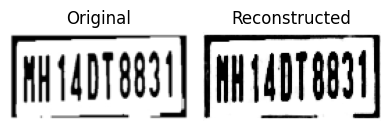

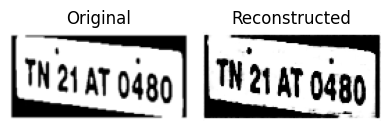

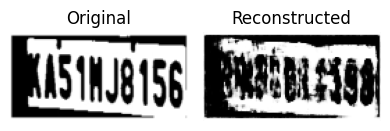

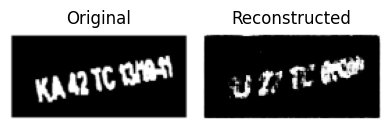

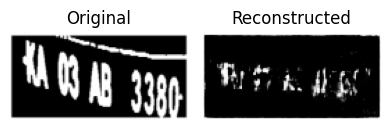

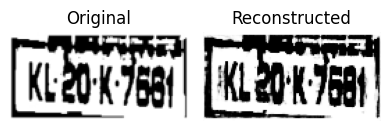

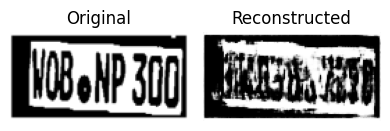

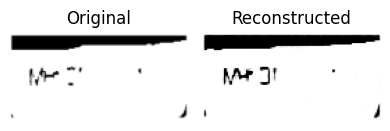

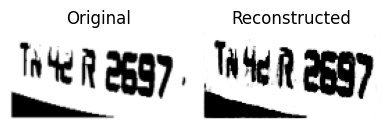

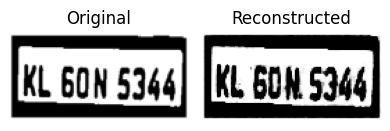

In [31]:
import torch
import matplotlib.pyplot as plt

def show_vae_reconstructions(model, data_loader, device, num_samples=10):
    model.eval()
    shown = 0

    with torch.no_grad():
        for x, _ in data_loader:
            x = x.to(device)

            # اگر forward تو این‌طوری است: recon, mu, logvar = model(x)
            recon, mu, logvar = model(x)

            # اگر forward فقط recon برمی‌گرداند، این خط را بکن: recon = model(x)

            batch_size = x.size(0)
            for i in range(batch_size):
                if shown >= num_samples:
                    return

                orig_img  = x[i].cpu().squeeze().numpy()
                recon_img = recon[i].cpu().squeeze().numpy()

                plt.figure(figsize=(4, 2))
                plt.subplot(1, 2, 1)
                plt.imshow(orig_img, cmap="gray")
                plt.title("Original")
                plt.axis("off")

                plt.subplot(1, 2, 2)
                plt.imshow(recon_img, cmap="gray")
                plt.title("Reconstructed")
                plt.axis("off")

                plt.tight_layout()
                plt.show()

                shown += 1
show_vae_reconstructions(model, test_loader, device, num_samples=10)


✅ VAE model saved: ./results/vae_model.pth


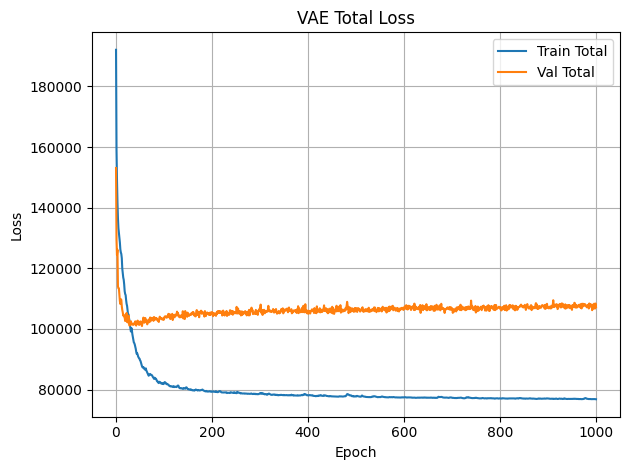

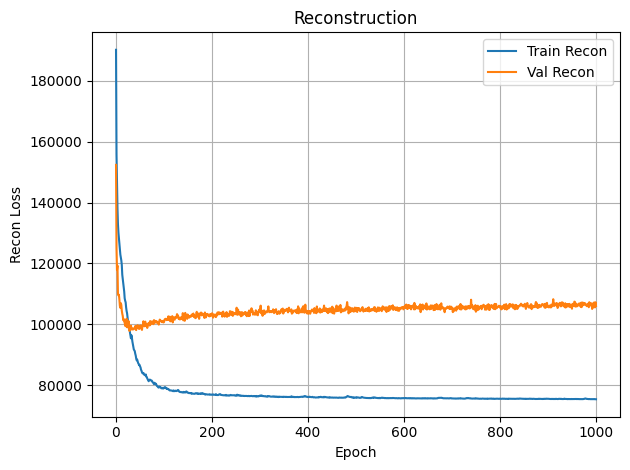

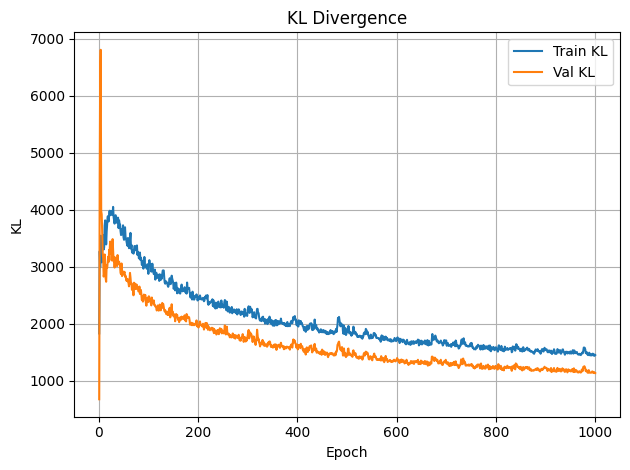

In [33]:
def plot_losses(h):
    ep = range(1, len(h['train_total'])+1)
    plt.figure(); 
    plt.plot(ep, h['train_total'], label='Train Total'); 
    if h['val_total']: plt.plot(ep, h['val_total'], label='Val Total')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('VAE Total Loss'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.savefig('vae_total_loss.png')

    plt.figure(); 
    plt.plot(ep, h['train_recon'], label='Train Recon'); 
    if h['val_recon']: plt.plot(ep, h['val_recon'], label='Val Recon')
    plt.xlabel('Epoch'); plt.ylabel('Recon Loss'); plt.title('Reconstruction'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.savefig('vae_recon_loss.png')

    plt.figure(); 
    plt.plot(ep, h['train_kl'], label='Train KL'); 
    if h['val_kl']: plt.plot(ep, h['val_kl'], label='Val KL')
    plt.xlabel('Epoch'); plt.ylabel('KL'); plt.title('KL Divergence'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.savefig('vae_kl_loss.png')

plot_losses(history)

# ذخیره مدل VAE
vae_path = "./results/vae_model.pth"
os.makedirs("results", exist_ok=True)
torch.save(model.state_dict(), vae_path)
print("✅ VAE model saved:", vae_path)



In [49]:
import pandas as pd

def extract_latents(data_loader, model, save_path, device='cpu'):
    model.eval()
    latents = []
    filenames = []

    with torch.no_grad():
        for i, (x, _) in enumerate(data_loader):
            x = x.to(device)
            mu, _ = model.encoder(x)
            latents.append(mu.cpu())

            # گرفتن نام فایل‌ها به تعداد batch جاری
            start_idx = i * data_loader.batch_size
            end_idx = start_idx + x.size(0)
            batch_filenames = [data_loader.dataset.samples[j][0] for j in range(start_idx, end_idx)]
            filenames.extend(batch_filenames)

    latents = torch.cat(latents, dim=0).numpy()
    df = pd.DataFrame(latents)
    df.insert(0, "filename", filenames)
    df.to_csv(save_path, index=False)
    print(f"✅ Latents saved to {save_path}")

train_loader_without_shuffle = DataLoader(train_data, batch_size=32, shuffle=False)
# اجرای استخراج برای هر بخش داده‌ها
extract_latents(train_loader_without_shuffle, model, "./results/train_latents.csv", device=device)
extract_latents(val_loader,   model, "./results/val_latents.csv", device=device)
extract_latents(test_loader,  model, "./results/test_latents.csv", device=device)


AttributeError: 'MetricMLP' object has no attribute 'encoder'

In [36]:
import torch
import pandas as pd
import numpy as np
from PIL import Image
import os
from tqdm import tqdm

# ---------- تنظیمات ----------
latent_csv_path = "./results/train_latents.csv"
decoded_img_dir = "./results/reconstructed_train_images"
os.makedirs(decoded_img_dir, exist_ok=True)

# ---------- بارگذاری latent vectors ----------
df = pd.read_csv(latent_csv_path)
filenames = df['filename'].values if 'filename' in df.columns else [f"{i:05d}.jpg" for i in range(len(df))]
latents = df.drop(columns=['filename']).values if 'filename' in df.columns else df.values
latents_tensor = torch.tensor(latents, dtype=torch.float32).to(device)

# ---------- بازسازی تصاویر ----------
model.eval()
with torch.no_grad():
    recon_imgs = model.decoder(latents_tensor).cpu()

# ---------- ذخیره تصاویر با PIL ----------
for img_tensor, fname in tqdm(zip(recon_imgs, filenames), total=len(filenames)):
    img_np = img_tensor.squeeze().numpy()  # (H, W)
    img_np = (img_np * 255).clip(0, 255).astype(np.uint8)
    img_pil = Image.fromarray(img_np, mode='L')
    img_pil.save(os.path.join(decoded_img_dir, os.path.basename(fname)))

print(f"✅ بازسازی و ذخیره تصاویر انجام شد: {decoded_img_dir}")


100%|██████████| 275/275 [00:00<00:00, 2854.91it/s]

✅ بازسازی و ذخیره تصاویر انجام شد: ./results/reconstructed_train_images


In [37]:
from ultralytics import YOLO
import numpy as np
import cv2

def plate_text_with_yolo(img_rgb, yolo_model, segment_characters, classifier_model):
    """
    img_rgb: تصویر ورودی در فضای RGB، shape = (H, W, 3)
    خروجی:
      plate_crop_rgb: کراپ پلاک (یا None)
      plate_text: متن پلاک به صورت string (یا None / "")
      chars_preds: لیست (تصویر کاراکتر، حرف پیش‌بینی شده)
    """
    # اجرای YOLO
    results = yolo_model.predict(img_rgb, verbose=False)
    if len(results) == 0 or results[0].boxes is None or len(results[0].boxes) == 0:
        return None, None, []

    # ساده‌ترین: اولین باکس (میتونی طبق conf sort هم بکنی)
    box = results[0].boxes.xyxy[0].cpu().numpy().astype(int)
    x1, y1, x2, y2 = box
    h, w, _ = img_rgb.shape
    x1 = max(0, x1); y1 = max(0, y1)
    x2 = min(w, x2); y2 = min(h, y2)

    plate_crop = img_rgb[y1:y2, x1:x2]

    # segmentation روی پلاک
    chars = segment_characters(plate_crop)
    if len(chars) == 0:
        return plate_crop, None, []

    # classifier روی هر کاراکتر
    preds = show_results(chars, classifier_model)
    plate_text = "".join(preds)

    chars_preds = list(zip(chars, preds))
    return plate_crop, plate_text, chars_preds


In [60]:
# def fix_dimension(img): 
#     new_img = np.zeros((28,28,3))
#     for i in range(3):
#         new_img[:,:,i] = img
#     return new_img

# def classify_characters(characters, classifier_model):
#     """
#     characters: list of numpy arrays (H, W) از segment_characters
#     خروجی: list از حروف پیش‌بینی‌شده (مثلا ['K','A','1',...])
#     """
#     dic = {i: c for i, c in enumerate('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')}

#     output = []
#     for ch in characters:
#         img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
#         img = fix_dimension(img_)
#         img = img.reshape(1, 28, 28, 3)
#         y_prob = classifier_model.predict(img, verbose=0)
#         y_ = np.argmax(y_prob, axis=1)[0]
#         output.append(dic[y_])

#     return output

# def plate_text_with_yolo(img_rgb, yolo_model, segment_characters, classifier_model):
#     """
#     img_rgb: تصویر RGB
#     خروجی:
#       plate_crop_rgb: کراپ پلاک (یا None)
#       plate_text: متن کامل پلاک (string یا None)
#       chars_preds: list[(char_img, char_pred)]
#     """
#     # results = yolo_model.predict(img_rgb, verbose=False)
#     results = yolo_model.predict(img_rgb, verbose=False, device='cpu')

    
#     if len(results) == 0 or results[0].boxes is None or len(results[0].boxes) == 0:
#         return None, None, []

#     box = results[0].boxes.xyxy[0].cpu().numpy().astype(int)
#     x1, y1, x2, y2 = box
#     h, w, _ = img_rgb.shape
#     x1 = max(0, x1); y1 = max(0, y1)
#     x2 = min(w, x2); y2 = min(h, y2)

#     plate_crop = img_rgb[y1:y2, x1:x2]

#     chars = segment_characters(plate_crop)
#     if len(chars) == 0:
#         return plate_crop, None, []

#     preds = classify_characters(chars, classifier_model)
#     plate_text = "".join(preds)
#     chars_preds = list(zip(chars, preds))
#     return plate_crop, plate_text, chars_preds



# import math
# import pandas as pd
# import torch
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# import os
# from IPython.display import clear_output

# def tensor_to_cv2img(tensor_img):
#     img = tensor_img.detach().cpu().numpy()
#     img = (img * 0.5 + 0.5) * 255  # اگر خروجی VAE در [-1,1] است
#     img = np.clip(img, 0, 255).astype(np.uint8)
#     img = np.squeeze(img, axis=0)  # (H, W)
#     img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#     return img


# def manual_label_split_with_yolo(
#     latent_csv_path,
#     vae_model,
#     classifier_model,
#     yolo_model,
#     segment_characters,
#     device="cpu",
#     output_csv_path=None,
#     max_samples=None,
# ):
#     df = pd.read_csv(latent_csv_path)
#     filenames = df["filename"].tolist()
#     latents = df.drop(columns=["filename"]).values
#     latents_tensor = torch.tensor(latents, dtype=torch.float32).to(device)

#     scores = []
#     pred_orig_list  = []
#     pred_recon_list = []   # اگر نخواستی ستون recon داشته باشی، می‌تونی بعداً حذفش کنی

#     total = len(df) if max_samples is None else min(len(df), max_samples)

#     for i in range(total):
#         clear_output(wait=True)
#         fname = filenames[i]

#         # --- ۱. بازسازی از latent (فقط برای نمایش) ---
#         z = latents_tensor[i].unsqueeze(0)
#         vae_model.eval()
#         with torch.no_grad():
#             recon = vae_model.decoder(z).squeeze(0)
#         recon_img = tensor_to_cv2img(recon)   # RGB

#         # --- ۲. خواندن تصویر اصلی ---
#         orig_bgr = cv2.imread(fname)
#         if orig_bgr is None:
#             orig_rgb = np.zeros_like(recon_img)
#         else:
#             orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)

#         # --- ۳. YOLO + classifier فقط روی ORIGINAL ---
#         plate_o, text_o, chars_preds_o = plate_text_with_yolo(
#             orig_rgb, yolo_model, segment_characters, classifier_model
#         )

#         # روی تصویر reconstruct هیچ عملیاتی انجام نمی‌دهیم
#         plate_r, text_r, chars_preds_r = None, None, []

#         pred_orig_list.append(text_o if text_o is not None else "")
#         # اگر می‌خواهی ستون recon خالی باشد:
#         pred_recon_list.append(text_r if text_r is not None else "")

#         # ---------- FIGURE 1: Original / Original plate crop / Recon ----------
#         cols_fig1 = 3
#         rows_fig1 = 1
#         plt.figure(figsize=(4 * cols_fig1, 4))

#         title_o = f"Original\nYOLO+clf: {text_o}" if text_o else "Original\nYOLO+clf: N/A"

#         # (۱) original
#         plt.subplot(rows_fig1, cols_fig1, 1)
#         plt.imshow(orig_rgb)
#         plt.title(title_o)
#         plt.axis("off")

#         # (۲) original plate crop (اگر داریم)
#         if plate_o is not None:
#             plt.subplot(rows_fig1, cols_fig1, 2)
#             plt.imshow(plate_o)
#             plt.title("Original plate crop")
#             plt.axis("off")
#         else:
#             plt.subplot(rows_fig1, cols_fig1, 2)
#             plt.imshow(np.zeros_like(recon_img))
#             plt.title("Original plate crop: N/A")
#             plt.axis("off")

#         # (۳) recon (فقط برای مقایسه)
#         plt.subplot(rows_fig1, cols_fig1, 3)
#         plt.imshow(recon_img)
#         plt.title("Reconstructed image")
#         plt.axis("off")

#         plt.suptitle(f"[{i+1}/{total}] {os.path.basename(fname)}")
#         plt.tight_layout()
#         plt.show()

#         # ---------- FIGURE 2: همه‌ی کاراکترهای ORIGINAL + پیش‌بینی ----------
#         if len(chars_preds_o) > 0:
#             n_chars = len(chars_preds_o)
#             cols = min(10, n_chars)
#             rows = math.ceil(n_chars / cols)

#             plt.figure(figsize=(3 * cols, 3 * rows))
#             for idx, (ch_img, ch_pred) in enumerate(chars_preds_o):
#                 plt.subplot(rows, cols, idx + 1)
#                 plt.imshow(ch_img, cmap="gray")
#                 plt.title(ch_pred)
#                 plt.axis("off")

#             plt.suptitle(f"Original characters ({n_chars})")
#             plt.tight_layout()
#             plt.show()
#         else:
#             print("⚠ روی تصویر اصلی هیچ کاراکتری سگمنت نشد.")

#         # --- ۵. گرفتن اسکور دستی ---
#         while True:
#             user_inp = input("Enter quality score (0-4) or 'q' to quit: ").strip()
#             if user_inp.lower() == "q":
#                 print("Stopping manual labeling.")
#                 total = i
#                 break
#             try:
#                 score = int(user_inp)
#                 if 0 <= score <= 4:
#                     scores.append(score)
#                     break
#                 else:
#                     print("⚠ فقط عدد بین ۰ تا ۴ وارد کن.")
#             except ValueError:
#                 print("⚠ ورودی نامعتبر، دوباره امتحان کن.")

#         if len(scores) < i + 1:
#             break

#     # --- ۶. ذخیره CSV ---
#     df_labeled = df.iloc[:len(scores)].copy()
#     df_labeled["manual_quality"]       = scores
#     df_labeled["pred_orig_yolo_clf"]   = pred_orig_list[:len(scores)]
#     df_labeled["pred_recon_yolo_clf"]  = pred_recon_list[:len(scores)]  # اگر لازم نیست، این خط و ستون را حذف کن

#     if output_csv_path is None:
#         output_csv_path = latent_csv_path.replace(".csv", "_labeled.csv")

#     df_labeled.to_csv(output_csv_path, index=False)
#     print(f"✅ Saved labeled CSV to: {output_csv_path}")


def manual_label_split_with_yolo(
    latent_csv_path,
    vae_model,
    classifier_model,
    yolo_model,
    segment_characters,
    device="cpu",
    output_csv_path=None,
    max_samples=None,
):
    df = pd.read_csv(latent_csv_path)
    filenames = df["filename"].tolist()
    latents = df.drop(columns=["filename"]).values
    latents_tensor = torch.tensor(latents, dtype=torch.float32).to(device)

    scores = []
    pred_orig_list  = []
    pred_recon_list = []

    total = len(df) if max_samples is None else min(len(df), max_samples)

    for i in range(total):
        clear_output(wait=True)
        fname = filenames[i]

        # --- ۱. بازسازی از latent ---
        z = latents_tensor[i].unsqueeze(0)
        vae_model.eval()
        with torch.no_grad():
            recon = vae_model.decoder(z).squeeze(0)
        recon_img = tensor_to_cv2img(recon)   # RGB

        # --- ۲. خواندن تصویر اصلی ---
        orig_bgr = cv2.imread(fname)
        if orig_bgr is None:
            orig_rgb = np.zeros_like(recon_img)
        else:
            orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)

        # --- ۳. YOLO + classifier روی ORIGINAL ---
        plate_o, text_o, chars_preds_o = plate_text_with_yolo(
            orig_rgb, yolo_model, segment_characters, classifier_model
        )

        # --- ۴. YOLO + classifier روی RECON ---
        plate_r, text_r, chars_preds_r = plate_text_with_yolo(
            recon_img, yolo_model, segment_characters, classifier_model
        )

        pred_orig_list.append(text_o if text_o is not None else "")
        pred_recon_list.append(text_r if text_r is not None else "")

        # ---------- FIGURE 1: Original / Recon / Recon plate crop ----------
        cols_fig1 = 3
        rows_fig1 = 1
        plt.figure(figsize=(4 * cols_fig1, 4))

        title_o = f"Original\nYOLO+clf: {text_o}" if text_o else "Original\nYOLO+clf: N/A"
        title_r = f"Recon\nYOLO+clf: {text_r}" if text_r else "Recon\nYOLO+clf: N/A"

        # (۱) original
        plt.subplot(rows_fig1, cols_fig1, 1)
        plt.imshow(orig_rgb)
        plt.title(title_o)
        plt.axis("off")

        # (۲) recon
        plt.subplot(rows_fig1, cols_fig1, 2)
        plt.imshow(recon_img)
        plt.title(title_r)
        plt.axis("off")

        # (۳) recon plate crop (اگر داریم)
        if plate_r is not None:
            plt.subplot(rows_fig1, cols_fig1, 3)
            plt.imshow(plate_r)
            plt.title("Recon plate crop")
            plt.axis("off")

        plt.suptitle(f"[{i+1}/{total}] {os.path.basename(fname)}")
        plt.tight_layout()
        plt.show()

        # ---------- FIGURE 2: همه‌ی کاراکترهای recon + پیش‌بینی ----------
        if len(chars_preds_r) > 0:
            n_chars = len(chars_preds_r)
            cols = min(10, n_chars)  # حداکثر ۱۰ ستون؛ اگه کمتر بود خود به خود کمتر میشه
            rows = math.ceil(n_chars / cols)

            plt.figure(figsize=(3 * cols, 3 * rows))
            for idx, (ch_img, ch_pred) in enumerate(chars_preds_r):
                plt.subplot(rows, cols, idx + 1)
                plt.imshow(ch_img, cmap="gray")
                plt.title(ch_pred)
                plt.axis("off")

            plt.suptitle(f"Recon characters ({n_chars})")
            plt.tight_layout()
            plt.show()
        else:
            print("⚠ روی تصویر بازسازی‌شده هیچ کاراکتری سگمنت نشد.")

        # --- ۵. گرفتن اسکور دستی ---
        while True:
            user_inp = input("Enter quality score (0-4) or 'q' to quit: ").strip()
            if user_inp.lower() == "q":
                print("Stopping manual labeling.")
                total = i
                break
            try:
                score = int(user_inp)
                if 0 <= score <= 4:
                    scores.append(score)
                    break
                else:
                    print("⚠ فقط عدد بین ۰ تا ۴ وارد کن.")
            except ValueError:
                print("⚠ ورودی نامعتبر، دوباره امتحان کن.")

        if len(scores) < i + 1:
            break

    # --- ۶. ذخیره CSV ---
    df_labeled = df.iloc[:len(scores)].copy()
    df_labeled["manual_quality"]       = scores
    df_labeled["pred_orig_yolo_clf"]   = pred_orig_list[:len(scores)]
    df_labeled["pred_recon_yolo_clf"]  = pred_recon_list[:len(scores)]

    if output_csv_path is None:
        output_csv_path = latent_csv_path.replace(".csv", "_labeled.csv")

    df_labeled.to_csv(output_csv_path, index=False)
    print(f"✅ Saved labeled CSV to: {output_csv_path}")



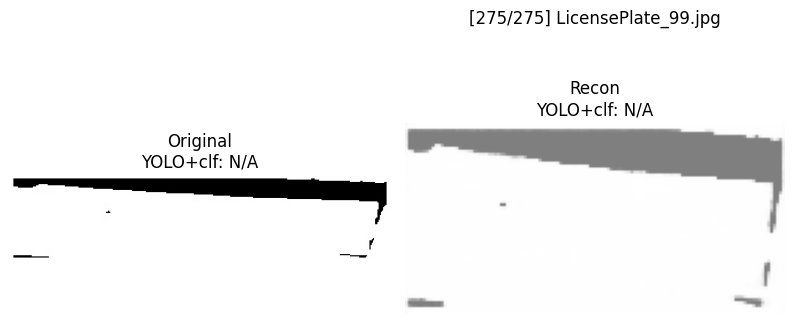

⚠ روی تصویر بازسازی‌شده هیچ کاراکتری سگمنت نشد.
✅ Saved labeled CSV to: ./results/train_latents_labeled.csv


In [ ]:
# manual_label_split_with_yolo(
#     latent_csv_path="./results/train_latents.csv",
#     vae_model=model,
#     classifier_model=classifier_model,
#     yolo_model=yolo_model,
#     segment_characters=segment_characters,
#     device=device,
#     output_csv_path="./results/train_latents_labeled.csv",
#     max_samples=None  # یا مثلا 200 برای تست
# )

# # تعریف transform مناسب برای VAE (مقیاس خاکستری، Resize، Normalize)
# transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
#     transforms.Resize((64, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

# # بارگذاری داده‌ها
# train_data = ImageFolder('./cropped_plates/train', transform=transform)
# val_data   = ImageFolder('./cropped_plates/valid', transform=transform)
# test_data  = ImageFolder('./cropped_plates/test', transform=transform)

# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
# test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)


# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res



import os
import pytesseract
from ultralytics import YOLO

# مسیر tesseract.exe (برای ویندوز)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

yolo_model = YOLO("license-plate-finetune-v1x.pt")
yolo_model.to('cpu')  # 👈 این خط را اضافه کن، YOLO فقط روی CPU



import tensorflow as tf
import json

classifier_model = tf.keras.models.load_model("analyze/classifier/classifier.keras",
                                   custom_objects={"F1Score": F1Score})

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# --- نکته مهم: latent_dim همان چیزی که در چک‌پوینت بوده، یعنی 64 ---
model = VAE(latent_dim=64).to(device)

state = torch.load('./results/vae_model.pth', map_location=device)
print("latent_dim in checkpoint (from fc_mu):", state['encoder.fc_mu.weight'].shape[0])
# باید 64 چاپ شود

model.load_state_dict(state)   # الان باید بدون خطا لود شود
model.eval()



with open("analyze/classifier/class_indices.json") as f:
    class_indices = json.load(f)
# اگر خواستی برگردونی از index به label:
idx_to_class = {v: k for k, v in class_indices.items()}

# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    # =========== 1) حذف نویزهای خیلی کوچک ===========
    filtered = []
    for ch in char_list:
        if ch.shape[0] < 15 or ch.shape[1] < 10:  # میتونی تغییر بدی
            continue
        filtered.append(ch)

    char_list = filtered

    # =========== 2) حذف duplicate ها بر اساس شباهت پیکسلی ===========
    unique_chars = []
    for ch in char_list:
        is_dup = False
        for uch in unique_chars:
            if np.mean(np.abs(ch.astype(np.float32) - uch.astype(np.float32))) < 8:
                is_dup = True
                break
        if not is_dup:
            unique_chars.append(ch)

    char_list = unique_chars

    # =========== 3) اگر هنوز خیلی زیاد بود، فقط بزرگ‌ترین‌ها را بردار ===========
    if len(char_list) > 10:   # پلاک واقعی بیشتر از 10 کاراکتر ندارد
        # بزرگ‌ترین segmentها از نظر مساحت
        areas = [(i, ch.shape[0] * ch.shape[1]) for i, ch in enumerate(char_list)]
        areas = sorted(areas, key=lambda x: x[1], reverse=True)
        keep_indices = [idx for idx, area in areas[:10]]
        char_list = [char_list[i] for i in keep_indices]

    # =========== 4) مرتب‌سازی چپ به راست ===========
    # براساس متوسط intensity در محور x
    char_list = sorted(char_list, key=lambda img: np.mean(img, axis=0).argmin())


    return char_list


manual_label_split_with_yolo(
    latent_csv_path="./results/train_latents.csv",
    vae_model=model,
    classifier_model=classifier_model,
    yolo_model=yolo_model,
    segment_characters=segment_characters,
    device=device,
    output_csv_path="./results/train_latents_labeled.csv",
    max_samples=None
)


In [64]:
print(df.columns.tolist())

['filename', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', 'manual_quality', 'pred_orig_yolo_clf', 'pred_recon_yolo_clf']


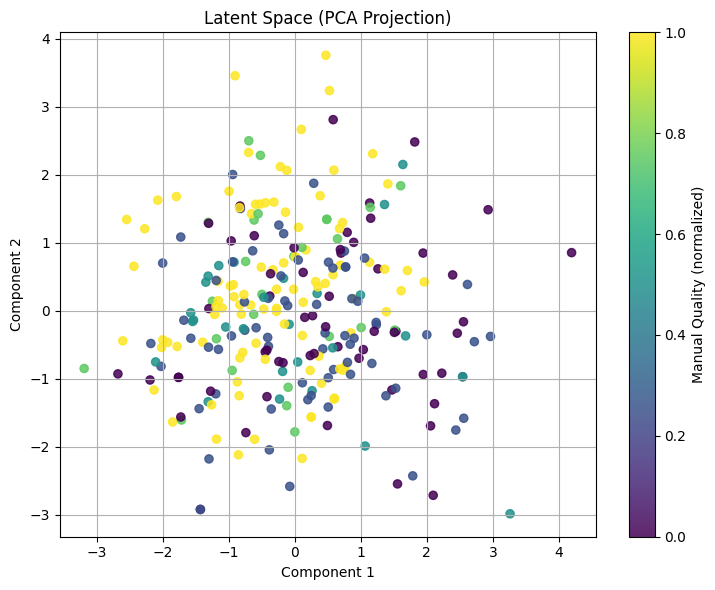

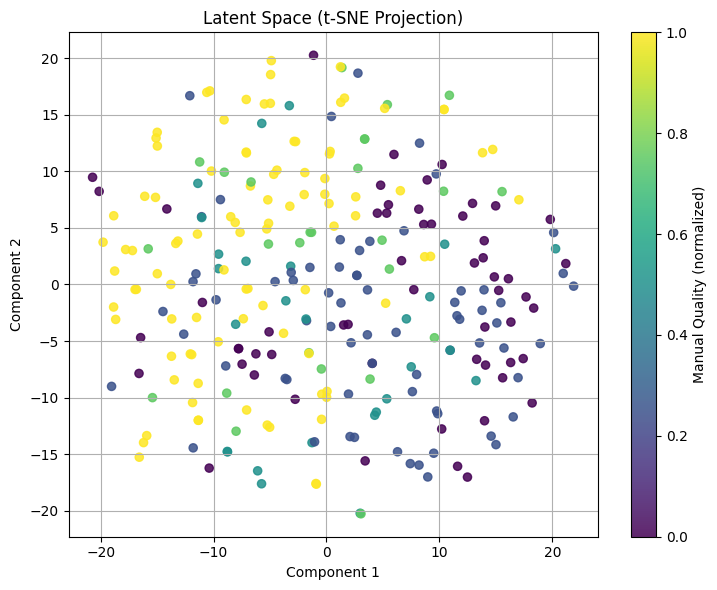

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

# خواندن فایل CSV
df = pd.read_csv('./results/train_latents_labeled.csv')

# استخراج بردارهای لیتنت و لیبل کیفیت
latent_cols = [col for col in df.columns if col.isdigit()]
z = df[latent_cols].values
quality = df['manual_quality'].values

# نرمال‌سازی کیفیت به بازه ۰ تا ۱ برای رنگ‌ها
quality_norm = MinMaxScaler().fit_transform(quality.reshape(-1, 1)).flatten()

# کاهش بعد با PCA و t-SNE
z_pca = PCA(n_components=2).fit_transform(z)
z_tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42).fit_transform(z)

# تابع رسم
def plot_latent(z_2d, title):
    plt.figure(figsize=(7.5, 6))
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=quality_norm, cmap='viridis', s=35, alpha=0.85)
    cbar = plt.colorbar(scatter)
    cbar.set_label('Manual Quality (normalized)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# رسم نمودارها
plot_latent(z_pca, 'Latent Space (PCA Projection)')
plot_latent(z_tsne, 'Latent Space (t-SNE Projection)')


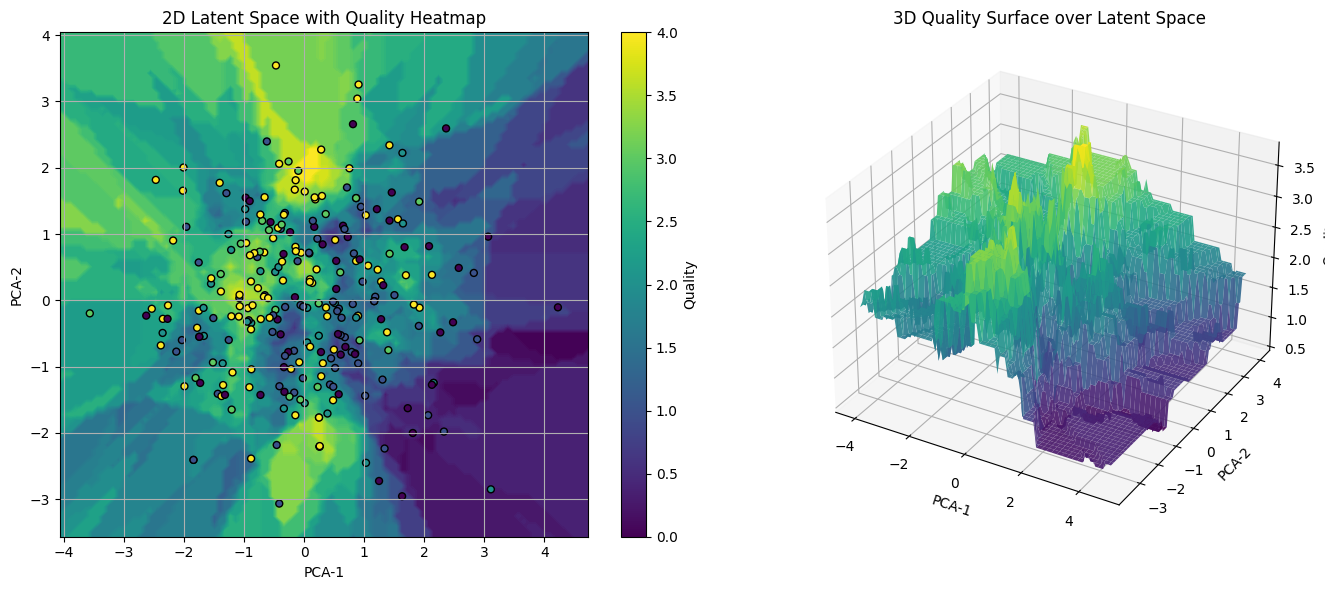

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import IsolationForest
from mpl_toolkits.mplot3d import Axes3D

df = pd.read_csv("./results/train_latents_labeled.csv")
latent_cols = [col for col in df.columns if col.isdigit()]
z = df[latent_cols].values
quality = df['manual_quality'].values

# حذف آوتلایرها
mask = IsolationForest(contamination=0.05, random_state=0).fit_predict(z) == 1
z_filtered = z[mask]
quality_filtered = quality[mask]

# کاهش بعد
pca = PCA(n_components=3)
z_3d = pca.fit_transform(z_filtered)
z_2d = z_3d[:, :2]

# مش‌بندی و میان‌یابی کیفیت
x_min, x_max = z_2d[:, 0].min() - 0.5, z_2d[:, 0].max() + 0.5
y_min, y_max = z_2d[:, 1].min() - 0.5, z_2d[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(z_2d, quality_filtered)
zz = knn.predict(grid).reshape(xx.shape)

# رسم نمودارها
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(1, 2, 1)
cf = ax1.contourf(xx, yy, zz, cmap='viridis', levels=100)
scatter = ax1.scatter(z_2d[:, 0], z_2d[:, 1], c=quality_filtered, cmap='viridis', edgecolor='k', s=25)
plt.colorbar(scatter, ax=ax1, label='Quality')
ax1.set_xlabel('PCA-1')
ax1.set_ylabel('PCA-2')
ax1.set_title('2D Latent Space with Quality Heatmap')
ax1.grid(True)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(xx, yy, zz, cmap='viridis', edgecolor='none', alpha=0.9)
ax2.set_xlabel('PCA-1')
ax2.set_ylabel('PCA-2')
ax2.set_zlabel('Quality')
ax2.set_title('3D Quality Surface over Latent Space')

plt.tight_layout()
plt.savefig("results/quality_surface.png", dpi=300)
plt.show()


In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv('./results/train_latents_labeled.csv')

# Extract features and binary labels
latent_cols = [col for col in df.columns if col.isdigit()]
X = df[latent_cols].values
y_raw = df['manual_quality'].values
y = (y_raw >= 3).astype(int)  # 0~2 => 0, 3~4 => 1

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42)

# Define models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

# Train and evaluate each model
results = {}
for name, _model in models.items():
    _model.fit(X_train, y_train)
    y_pred = _model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = report['weighted avg']

results_df = pd.DataFrame(results).T[['precision', 'recall', 'f1-score']]
results_df


precision    recall  f1-score
RandomForest         0.767857  0.738095  0.730612
GradientBoosting     0.666667  0.666667  0.666667
LogisticRegression   0.791667  0.785714  0.784615
SVM                  0.881818  0.880952  0.880885

In [3]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# بارگذاری داده‌های آموزش
df = pd.read_csv('./results/train_latents_labeled.csv')

# استخراج ویژگی‌ها و تبدیل کیفیت به برچسب‌های باینری
latent_cols = [col for col in df.columns if col.isdigit()]
X = df[latent_cols].values
y = df['manual_quality'].apply(lambda q: 1 if q >= 3 else 0).values

# آموزش مدل SVM
SVC_model = SVC(kernel='rbf', probability=True, random_state=42)
SVC_model.fit(X, y)

# --- اعمال مدل روی داده‌های تست ---
latent_test = pd.read_csv('./results/test_latents.csv')
X_test = latent_test[latent_cols].values
test_preds = SVC_model.predict(X_test)
latent_test['predicted_quality'] = test_preds
latent_test.to_csv('./results/test_latents_labeled.csv', index=False)

# --- اعمال مدل روی داده‌های ولیدیشن ---
latent_valid = pd.read_csv('./results/val_latents.csv')
X_valid = latent_valid[latent_cols].values
valid_preds = SVC_model.predict(X_valid)
latent_valid['predicted_quality'] = valid_preds
latent_valid.to_csv('./results/val_latents_labeled.csv', index=False)


Epoch 5 - Loss: 0.6820
Epoch 10 - Loss: 0.6597
Epoch 15 - Loss: 0.6575
Epoch 20 - Loss: 0.6875
Epoch 25 - Loss: 0.7389
Epoch 30 - Loss: 0.6977
Epoch 35 - Loss: 0.6767
Epoch 40 - Loss: 0.7362
Epoch 45 - Loss: 0.5678
Epoch 50 - Loss: 0.7614


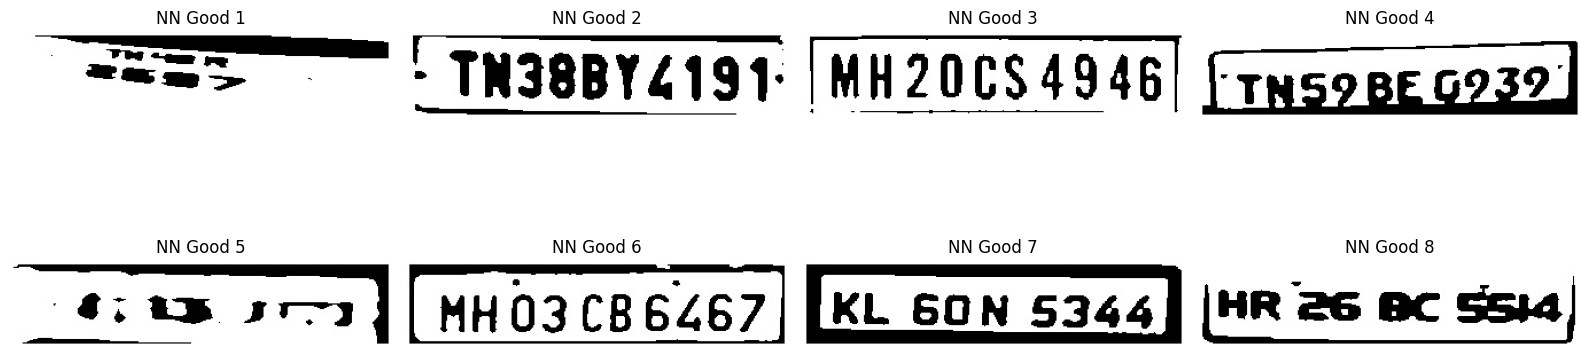

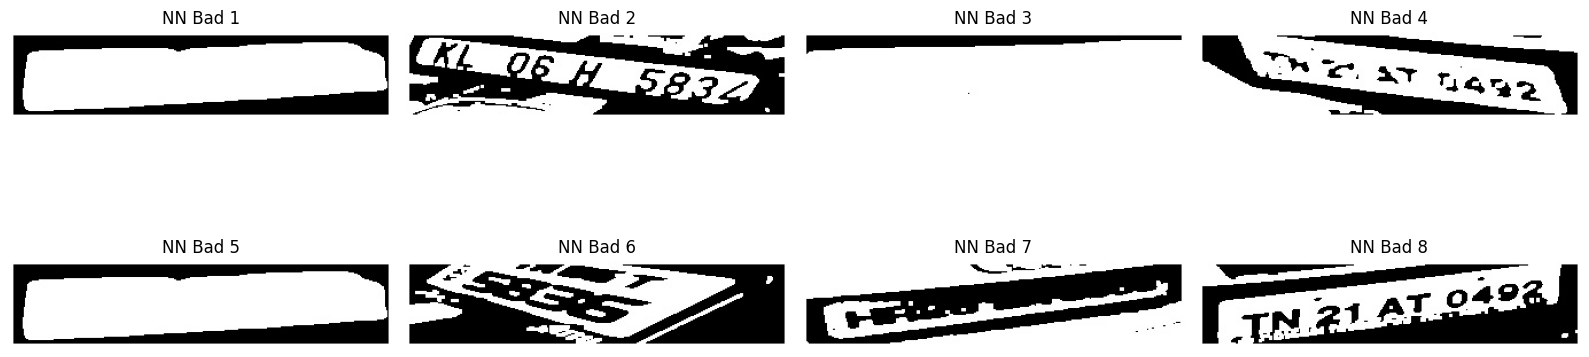

In [38]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Load dataset
df = pd.read_csv('./results/train_latents_labeled.csv')

# Filter only clean good/bad samples (0,1,2 => bad ; 3,4 => good)
df = df[df['manual_quality'].isin([0,1,2,3,4])].copy()
df['label'] = df['manual_quality'].apply(lambda q: 1 if q >= 3 else 0)

# Compute latent metrics if not already available
if 'KL' not in df.columns:
    def compute_metrics(row):
        mu = row[[str(i) for i in range(64)]].values.astype(float)
        var = np.ones_like(mu)  # assuming logvar unavailable
        kl = 0.5 * np.sum(var + mu**2 - 1 - np.log(var))
        trace = np.sum(var)
        entropy = 0.5 * (64 * (1 + np.log(2 * np.pi)) + np.sum(np.log(var)))
        determinant = np.prod(var)
        mahalanobis = mu @ np.diag(1.0 / var) @ mu
        return pd.Series([kl, trace, entropy, determinant, mahalanobis])

    df[['KL', 'Trace', 'Entropy', 'Determinant', 'Mahalanobis']] = df.apply(compute_metrics, axis=1)

# Features and labels
features = ['KL', 'Trace', 'Entropy', 'Determinant', 'Mahalanobis']
X = df[features].values
y = df['label'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=32, shuffle=True)

# Define a stronger neural network
class MetricMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = MetricMLP()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train
for epoch in range(50):
    for xb, yb in loader:
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1} - Loss: {loss.item():.4f}")

# Predict
with torch.no_grad():
    preds = model(X_tensor).squeeze().numpy()
df['score'] = preds
df['predicted_label'] = (df['score'] >= 0.5).astype(int)

# Show best/worst
top_good = df[df['predicted_label']==1].sort_values('score', ascending=False).head(8)['filename'].values
top_bad = df[df['predicted_label']==0].sort_values('score', ascending=True).head(8)['filename'].values

# Plot

def plot_images(filenames, title, image_dir, rows=2, cols=4):
    plt.figure(figsize=(16, 6))
    for i, fname in enumerate(filenames):
        img_path = os.path.join(image_dir, fname)
        if not os.path.exists(img_path):
            print(f"❌ File not found: {img_path}")
            continue
        img = mpimg.imread(img_path)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{title} {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(top_good, title="NN Good", image_dir="./")
plot_images(top_bad, title="NN Bad", image_dir="./")


In [50]:
train_loader_without_shuffle = DataLoader(train_data, batch_size=32, shuffle=False)

In [66]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm

# ========== تعریف متریک‌ها ==========
def compute_kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

def compute_entropy(logvar):
    latent_dim = logvar.shape[1]
    return 0.5 * (latent_dim * (1 + torch.log(torch.tensor(2 * torch.pi))) + torch.sum(logvar, dim=1))

# ========== تابع اصلی استخراج ==========
def extract_metrics(model, dataloader, label_df, dataset_name, device='cpu'):
    model.eval()
    model.to(device)
    
    all_records = []

    with torch.no_grad():
        for i, (x, _) in enumerate(tqdm(dataloader, desc=f"Processing {dataset_name}")):
            x = x.to(device)
            recon, mu, logvar = model(x)
            
            batch_size = x.size(0)
            mse = F.mse_loss(recon, x, reduction='none').view(batch_size, -1).mean(dim=1).cpu().numpy()
            kl = compute_kl_divergence(mu, logvar).cpu().numpy()
            entropy = compute_entropy(logvar).cpu().numpy()

            filenames = label_df.iloc[i * batch_size: i * batch_size + batch_size]['filename'].values
            manual_q = label_df.iloc[i * batch_size: i * batch_size + batch_size].get('manual_quality', pd.Series([np.nan]*batch_size)).values
            predicted_q = label_df.iloc[i * batch_size: i * batch_size + batch_size].get('predicted_quality', pd.Series([np.nan]*batch_size)).values

            for j in range(batch_size):
                # انتخاب بهترین کیفیت در دسترس
                if not np.isnan(manual_q[j]):
                    final_quality = manual_q[j]
                elif not np.isnan(predicted_q[j]):
                    final_quality = predicted_q[j]
                else:
                    final_quality = np.nan

                all_records.append({
                    'filename': filenames[j],
                    'quality': final_quality,
                    'mse': mse[j],
                    'kl_divergence': kl[j],
                    'entropy': entropy[j],
                    'set': dataset_name
                })


    return pd.DataFrame(all_records)

# ========== بارگذاری فایل‌های CSV لیبل ==========
df_train = pd.read_csv("./results/train_latents_labeled.csv")
df_val = pd.read_csv("./results/val_latents_labeled.csv")
df_test = pd.read_csv("./results/test_latents_labeled.csv")

# ========== اجرا روی هر دیتاست ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE(latent_dim=64).to(device)

state = torch.load('./results/vae_model.pth', map_location=device)
print("latent_dim in checkpoint (from fc_mu):", state['encoder.fc_mu.weight'].shape[0])
# باید 64 چاپ شود

model.load_state_dict(state)   # الان باید بدون خطا لود شود
model.eval()

df_train_metrics = extract_metrics(model, train_loader_without_shuffle, df_train, "train", device)
df_val_metrics   = extract_metrics(model, val_loader, df_val, "val", device)
df_test_metrics  = extract_metrics(model, test_loader, df_test, "test", device)

# ========== ذخیره نهایی ==========
df_all = pd.concat([df_train_metrics, df_val_metrics, df_test_metrics], ignore_index=True)
df_all.to_csv("./results/all_metrics.csv", index=False)
print("✅ فایل all_metrics.csv ذخیره شد.")


C:\Users\Mohammad Hossein\AppData\Local\Temp\ipykernel_10228\249349322.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('./results/vae_model.pth', map

latent_dim in checkpoint (from fc_mu): 64


Processing test: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

✅ فایل all_metrics.csv ذخیره شد.


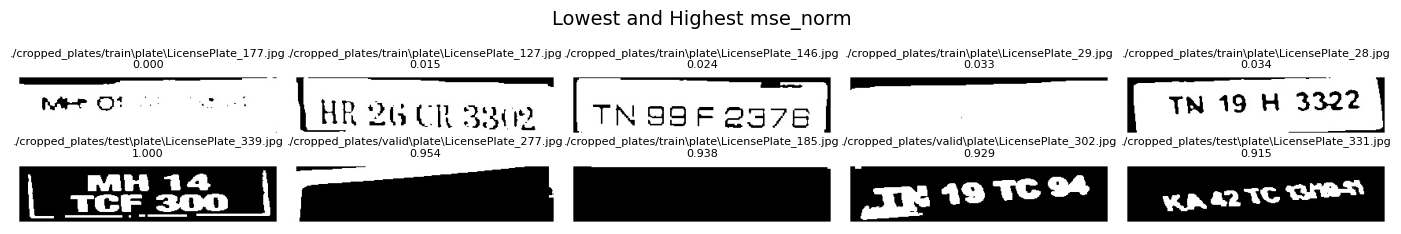

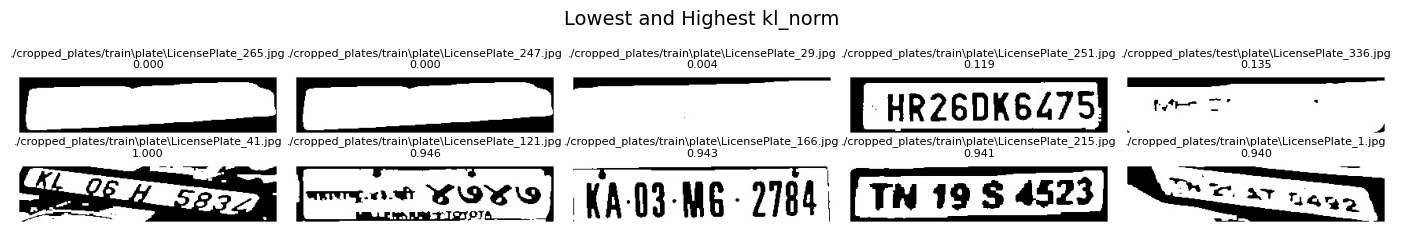

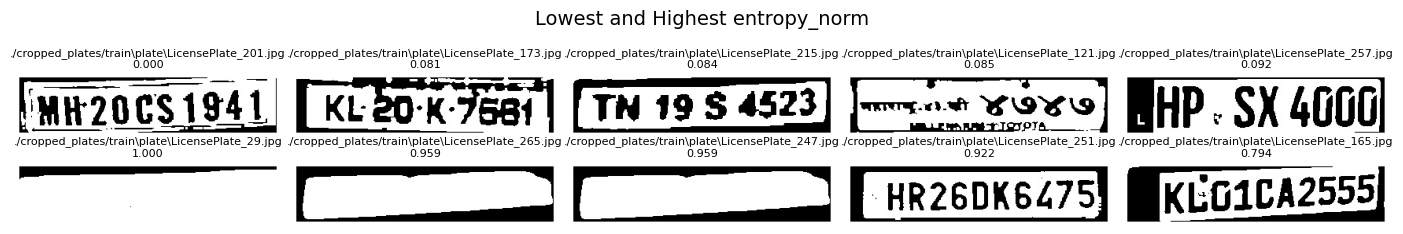

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# مسیر فایل و پوشه تصاویر
csv_path = "./results/all_metrics.csv"
image_dir = "./"  # تغییر بده اگر مسیر دیگه‌ای داری

# 1️⃣ خواندن فایل و بررسی
df = pd.read_csv(csv_path)
assert all(col in df.columns for col in ['filename', 'mse', 'kl_divergence', 'entropy'])

# 2️⃣ نرمال‌سازی متریک‌ها برای مقایسه بهتر
def normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

df["mse_norm"] = normalize(df["mse"])
df["kl_norm"] = normalize(df["kl_divergence"])
df["entropy_norm"] = normalize(df["entropy"])

# 3️⃣ تابع نمایش تصاویر بر اساس مقدار متریک
def plot_best_worst(df, score_col, image_dir="./", n=5):
    best = df.sort_values(score_col, ascending=True).head(n)
    worst = df.sort_values(score_col, ascending=False).head(n)

    fig, axes = plt.subplots(2, n, figsize=(n*2.8, 2.5))
    fig.suptitle(f"Lowest and Highest {score_col}", fontsize=14)

    for i in range(n):
        for group, row in zip([0, 1], [best.iloc[i], worst.iloc[i]]):
            img_path = os.path.join(image_dir, row["filename"])
            try:
                img = mpimg.imread(img_path)
                axes[group, i].imshow(img, cmap='gray')
                axes[group, i].set_title(f"{row['filename']}\n{row[score_col]:.3f}", fontsize=8)
                axes[group, i].axis('off')
            except Exception as e:
                print(f"⚠️ Image {img_path} not found or error: {e}")
                axes[group, i].axis('off')

    plt.tight_layout()
    plt.show()

# 4️⃣ اجرا برای هر متریک
plot_best_worst(df, "mse_norm", image_dir=image_dir)
plot_best_worst(df, "kl_norm", image_dir=image_dir)
plot_best_worst(df, "entropy_norm", image_dir=image_dir)



📊 گزارش ارزیابی:
              precision    recall  f1-score   support

           0      0.831     0.845     0.838        58
           1      0.625     0.600     0.612        25

    accuracy                          0.771        83
   macro avg      0.728     0.722     0.725        83
weighted avg      0.769     0.771     0.770        83



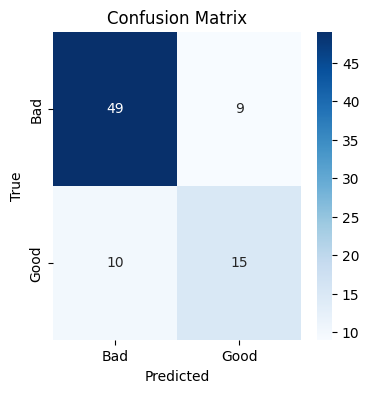


🖼️ نمونه‌هایی از تصاویر تست:


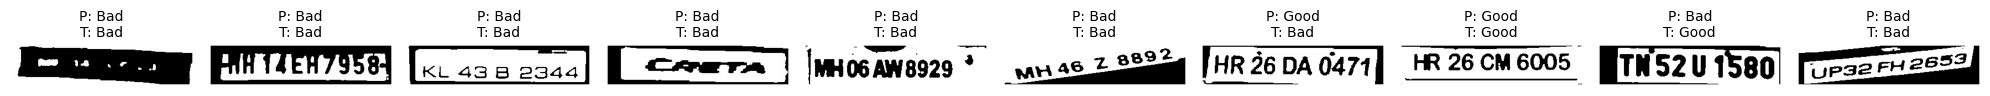

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# ⚙️ مسیر تصویرها
IMAGE_DIR = './'  # تنظیم کن به مسیر واقعی تصویرها اگر فرق داره

# 1️⃣ خواندن داده
df = pd.read_csv('./results/all_metrics.csv')

# 2️⃣ تعریف ویژگی‌ها و نرمال‌سازی
def normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

df['mse_norm'] = normalize(df['mse'])
df['kl_norm'] = normalize(df['kl_divergence'])
df['entropy_norm'] = normalize(df['entropy'])

# 3️⃣ برچسب باینری
df['label'] = df['quality'].apply(lambda x: 1 if x >= 3 else 0)

# 4️⃣ آموزش مدل
X = df[['mse_norm', 'kl_norm', 'entropy_norm']].values
y = df['label'].values
filenames = df['filename'].values

X_train, X_test, y_train, y_test, filenames_train, filenames_test = train_test_split(
    X, y, filenames, test_size=0.2, random_state=42, stratify=y
)

clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
clf.fit(X_train, y_train)

# 5️⃣ ارزیابی
y_pred = clf.predict(X_test)

print("\n📊 گزارش ارزیابی:")
print(classification_report(y_test, y_pred, digits=3))

# 6️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 7️⃣ نمایش ۱۰ تصویر از تست با پیش‌بینی و لیبل اصلی
print("\n🖼️ نمونه‌هایی از تصاویر تست:")

def show_predictions_with_images(filenames, y_true, y_pred, max_show=10):
    plt.figure(figsize=(20, 4))
    shown = 0
    for i in range(len(filenames)):
        if shown >= max_show:
            break
        img_path = os.path.join(IMAGE_DIR, filenames[i])
        if not os.path.exists(img_path):
            print(f"❌ تصویر یافت نشد: {img_path}")
            continue
        img = mpimg.imread(img_path)
        plt.subplot(1, max_show, shown + 1)
        plt.imshow(img, cmap='gray')
        pred_label = "Good" if y_pred[i] == 1 else "Bad"
        true_label = "Good" if y_true[i] == 1 else "Bad"
        plt.title(f"P: {pred_label}\nT: {true_label}", fontsize=10)
        plt.axis('off')
        shown += 1
    plt.tight_layout()
    plt.show()

show_predictions_with_images(filenames_test, y_test, y_pred, max_show=10)


In [74]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [90]:
# import pandas as pd
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# import seaborn as sns

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier
# # import xgboost as xgb

# # ⚙️ مسیر تصویرها
# IMAGE_DIR = './'  # تغییر بده اگر جای دیگه‌ست

# # 1️⃣ خواندن داده و نرمال‌سازی
# df = pd.read_csv('./results/all_metrics.csv')
# def normalize(arr): return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

# df['mse_norm'] = normalize(df['mse'])
# df['kl_norm'] = normalize(df['kl_divergence'])
# df['entropy_norm'] = normalize(df['entropy'])
# df['label'] = df['quality'].apply(lambda x: 1 if x >= 3 else 0)

# X = df[['mse_norm', 'kl_norm', 'entropy_norm']].values
# y = df['label'].values
# filenames = df['filename'].values

# X_train, X_test, y_train, y_test, fn_train, fn_test = train_test_split(
#     X, y, filenames, test_size=0.2, random_state=42, stratify=y
# )

# # 2️⃣ تعریف مدل‌ها
# models = {
#     'LogReg': LogisticRegression(),
#     'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5),
#     # 'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
#     'SVM': SVC(probability=True),
#     'MLP': MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=1)
# }

# # 3️⃣ آموزش و ارزیابی
# def evaluate_model(name, model, X_train, y_train, X_test, y_test):
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     print(f"\n📊 {name} Classification Report:")
#     print(classification_report(y_test, y_pred, digits=3))
#     cm = confusion_matrix(y_test, y_pred)
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
#     plt.title(f"{name} Confusion Matrix")
#     plt.xlabel("Predicted")
#     plt.ylabel("True")
#     plt.show()
#     return y_pred

# # 4️⃣ نمایش تصویر
# def show_predictions(name, y_true, y_pred, filenames, max_show=10):
#     plt.figure(figsize=(20, 4))
#     shown = 0
#     for i in range(len(filenames)):
#         if shown >= max_show: break
#         img_path = os.path.join(IMAGE_DIR, filenames[i])
#         if not os.path.exists(img_path):
#             print(f"❌ تصویر یافت نشد: {img_path}")
#             continue
#         img = mpimg.imread(img_path)
#         plt.subplot(1, max_show, shown + 1)
#         plt.imshow(img, cmap='gray')
#         pred_label = "Good" if y_pred[i] == 1 else "Bad"
#         true_label = "Good" if y_true[i] == 1 else "Bad"
#         plt.title(f"{name}\nP:{pred_label} | T:{true_label}", fontsize=9)
#         plt.axis('off')
#         shown += 1
#     plt.tight_layout()
#     plt.show()

# # 5️⃣ اجرا برای همه مدل‌ها
# for name, model in models.items():
#     y_pred = evaluate_model(name, model, X_train, y_train, X_test, y_test)
#     show_predictions(name, y_test, y_pred, fn_test)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# مسیر ذخیره نتایج
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
RESULTS_DIR = f'./results/experiments/exp_{timestamp}'
os.makedirs(RESULTS_DIR, exist_ok=True)

# تنظیمات اولیه
IMAGE_DIR = './'

# خواندن و آماده‌سازی داده
df = pd.read_csv('./results/all_metrics.csv')
def normalize(arr): return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
df['mse_norm'] = normalize(df['mse'])
df['kl_norm'] = normalize(df['kl_divergence'])
df['entropy_norm'] = normalize(df['entropy'])
df['label'] = df['quality'].apply(lambda x: 1 if x >= 3 else 0)

X = df[['mse_norm', 'kl_norm', 'entropy_norm']].values
y = df['label'].values
filenames = df['filename'].values

X_train, X_test, y_train, y_test, fn_train, fn_test = train_test_split(
    X, y, filenames, test_size=0.2, random_state=42, stratify=y
)

# مدل‌ها
models = {
    'LogReg': LogisticRegression(),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5),
    'SVM': SVC(probability=True),
    'MLP': MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=1)
}

# آموزش و ذخیره
def evaluate_and_save(name, model, X_train, y_train, X_test, y_test, filenames):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    # 📄 ذخیره گزارش
    report_text = classification_report(y_test, y_pred, digits=3)
    with open(os.path.join(RESULTS_DIR, f"{name}_report.txt"), 'w') as f:
        f.write(f"Balanced Accuracy: {bal_acc:.4f}\n\n")
        f.write(report_text)

    # 📊 ذخیره ماتریس اغتشاش
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
    plt.title(f"{name} - Confusion Matrix\nBalanced Acc: {bal_acc:.3f}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, f"{name}_confusion_matrix.png"))
    plt.close()

    # 🖼 نمایش تصاویر
    max_show = 10
    plt.figure(figsize=(20, 4))
    shown = 0
    for i in range(len(filenames)):
        if shown >= max_show: break
        path = os.path.join(IMAGE_DIR, filenames[i])
        if not os.path.exists(path): continue
        img = mpimg.imread(path)
        plt.subplot(1, max_show, shown+1)
        plt.imshow(img, cmap='gray')
        pred_label = "Good" if y_pred[i]==1 else "Bad"
        true_label = "Good" if y_test[i]==1 else "Bad"
        plt.title(f"{name}\nP:{pred_label} | T:{true_label}", fontsize=9)
        plt.axis('off')
        shown += 1
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, f"{name}_predictions.png"))
    plt.close()

# اجرای همه مدل‌ها
for name, model in models.items():
    evaluate_and_save(name, model, X_train, y_train, X_test, y_test, fn_test)


C:\Users\Mohammad Hossein\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [85]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader, TensorDataset
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# # 📦 داده‌های آماده
# X_train_torch = torch.tensor(X_train_bal, dtype=torch.float32)
# y_train_torch = torch.tensor(y_train_bal, dtype=torch.float32)
# X_test_torch  = torch.tensor(X_test, dtype=torch.float32)
# y_test_torch  = torch.tensor(y_test, dtype=torch.float32)

# train_dataset = TensorDataset(X_train_torch, y_train_torch)
# test_dataset = TensorDataset(X_test_torch, y_test_torch)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# # 🔧 Transformer-based MLP
# class TabularTransformer(nn.Module):
#     def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2):
#         super().__init__()
#         self.embedding = nn.Linear(input_dim, d_model)
#         encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=128, dropout=0.1, batch_first=True)
#         self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
#         self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
#         self.classifier = nn.Sequential(
#             nn.LayerNorm(d_model),
#             nn.Linear(d_model, 1)
#         )

#     def forward(self, x):
#         B, D = x.size()
#         x = self.embedding(x).unsqueeze(1)  # (B, 1, d_model)
#         cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, d_model)
#         x = torch.cat([cls_tokens, x], dim=1)  # prepend cls token
#         x = self.encoder(x)
#         cls_out = x[:, 0]  # first token output
#         return self.classifier(cls_out).squeeze(1)

# # 🚀 آموزش مدل
# def train_transformer_model(model, train_loader, test_loader, n_epochs=20, lr=1e-3, device='cpu'):
#     model = model.to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     loss_fn = nn.BCEWithLogitsLoss()

#     for epoch in range(n_epochs):
#         model.train()
#         total_loss = 0
#         for xb, yb in train_loader:
#             xb, yb = xb.to(device), yb.to(device)
#             logits = model(xb)
#             loss = loss_fn(logits, yb)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
#         print(f"Epoch {epoch+1}: loss={total_loss/len(train_loader):.4f}")

#     return model

# # 📊 ارزیابی مدل
# def evaluate_transformer_model(model, test_loader, y_test, filenames, name="Transformer", max_show=10):
#     model.eval()
#     preds = []
#     with torch.no_grad():
#         for xb, _ in test_loader:
#             xb = xb.to(next(model.parameters()).device)
#             out = torch.sigmoid(model(xb))
#             preds.extend(out.cpu().numpy())
#     y_pred = (np.array(preds) > 0.5).astype(int)

#     # گزارش
#     print(f"\n📊 {name} Classification Report:")
#     print(classification_report(y_test, y_pred, digits=3))
#     cm = confusion_matrix(y_test, y_pred)
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
#     plt.title(f"{name} Confusion Matrix")
#     plt.xlabel("Predicted")
#     plt.ylabel("True")
#     plt.show()

#     # نمونه تصاویر
#     plt.figure(figsize=(20, 4))
#     shown = 0
#     for i in range(len(filenames)):
#         if shown >= max_show: break
#         path = os.path.join(IMAGE_DIR, filenames[i])
#         if not os.path.exists(path): continue
#         img = mpimg.imread(path)
#         plt.subplot(1, max_show, shown+1)
#         plt.imshow(img, cmap='gray')
#         plt.title(f"{name}\nP:{'Good' if y_pred[i]==1 else 'Bad'} | T:{'Good' if y_test[i]==1 else 'Bad'}", fontsize=9)
#         plt.axis('off')
#         shown += 1
#     plt.tight_layout()
#     plt.show()

# # ⚙️ اجرا
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# transformer_model = TabularTransformer(input_dim=3)
# transformer_model = train_transformer_model(transformer_model, train_loader, test_loader, device=device)
# evaluate_transformer_model(transformer_model, test_loader, y_test, fn_test, name="Tabular Transformer")

import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from datetime import datetime

# 📂 ساخت پوشه برای ذخیره نتایج
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
RESULTS_DIR = f'./results/experiments/exp_transformer_{timestamp}'
os.makedirs(RESULTS_DIR, exist_ok=True)

# 🔧 مدل Transformer
class TabularTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=128, dropout=0.1, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):
        B, D = x.size()
        x = self.embedding(x).unsqueeze(1)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = self.encoder(x)
        cls_out = x[:, 0]
        return self.classifier(cls_out).squeeze(1)

# 🚀 آموزش مدل
def train_transformer_model(model, train_loader, n_epochs=20, lr=1e-3, device='cpu'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: loss={total_loss/len(train_loader):.4f}")
    return model

# 📊 ارزیابی و ذخیره نتایج
def evaluate_transformer_model(model, test_loader, y_test, filenames, name="Transformer", image_dir='./', max_show=10):
    model.eval()
    preds = []
    with torch.no_grad():
        for xb, _ in test_loader:
            xb = xb.to(next(model.parameters()).device)
            out = torch.sigmoid(model(xb))
            preds.extend(out.cpu().numpy())
    y_pred = (np.array(preds) > 0.5).astype(int)

    # 🧾 گزارش و دقت متعادل
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    report_text = classification_report(y_test, y_pred, digits=3)

    with open(os.path.join(RESULTS_DIR, f"{name}_report.txt"), 'w') as f:
        f.write(f"Balanced Accuracy: {bal_acc:.4f}\n\n")
        f.write(report_text)

    # 📉 ماتریس اغتشاش
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
    plt.title(f"{name} - Confusion Matrix\nBalanced Acc: {bal_acc:.3f}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, f"{name}_confusion_matrix.png"))
    plt.close()

    # 🖼 ذخیره تصاویر نمونه
    plt.figure(figsize=(20, 4))
    shown = 0
    for i in range(len(filenames)):
        if shown >= max_show: break
        path = os.path.join(image_dir, filenames[i])
        if not os.path.exists(path): continue
        img = mpimg.imread(path)
        plt.subplot(1, max_show, shown+1)
        plt.imshow(img, cmap='gray')
        pred_label = "Good" if y_pred[i]==1 else "Bad"
        true_label = "Good" if y_test[i]==1 else "Bad"
        plt.title(f"{name}\nP:{pred_label} | T:{true_label}", fontsize=9)
        plt.axis('off')
        shown += 1
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, f"{name}_predictions.png"))
    plt.close()

# ⚙️ اجرا
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer_model = TabularTransformer(input_dim=3)
transformer_model = train_transformer_model(transformer_model, train_loader, n_epochs=20, lr=1e-3, device=device)
evaluate_transformer_model(transformer_model, test_loader, y_test, fn_test, name="TabularTransformer", image_dir=IMAGE_DIR)


Epoch 1: loss=0.5811
Epoch 2: loss=0.5167
Epoch 3: loss=0.5254
Epoch 4: loss=0.5041
Epoch 5: loss=0.4996
Epoch 6: loss=0.5144
Epoch 7: loss=0.5114
Epoch 8: loss=0.5106
Epoch 9: loss=0.4873
Epoch 10: loss=0.5126
Epoch 11: loss=0.5066
Epoch 12: loss=0.5050
Epoch 13: loss=0.4978
Epoch 14: loss=0.4945
Epoch 15: loss=0.4915
Epoch 16: loss=0.4877
Epoch 17: loss=0.4896
Epoch 18: loss=0.4944
Epoch 19: loss=0.4902
Epoch 20: loss=0.4973


In [89]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.utils import resample

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# ⚙️ مسیر‌ها
RESULT_DIR = "./results/robust_transformer"
IMAGE_DIR = "./"
os.makedirs(RESULT_DIR, exist_ok=True)

# 📥 خواندن و آماده‌سازی داده
df = pd.read_csv('./results/all_metrics.csv')

def normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

df['mse_norm'] = normalize(df['mse'])
df['kl_norm'] = normalize(df['kl_divergence'])
df['entropy_norm'] = normalize(df['entropy'])
df['label'] = df['quality'].apply(lambda x: 1 if x >= 3 else 0)

X = df[['mse_norm', 'kl_norm', 'entropy_norm']].values
y = df['label'].values
filenames = df['filename'].values

# ⚖️ بالانس کردن داده‌ها
X_df = pd.DataFrame(X, columns=["mse", "kl", "entropy"])
X_df["label"] = y
X_df["filename"] = filenames
df_pos = X_df[X_df["label"] == 1]
df_neg = X_df[X_df["label"] == 0]
df_neg_down = resample(df_neg, replace=False, n_samples=len(df_pos), random_state=42)
df_balanced = pd.concat([df_pos, df_neg_down])

X_bal = df_balanced[["mse", "kl", "entropy"]].values
y_bal = df_balanced["label"].values
fn_bal = df_balanced["filename"].values

X_train, X_test, y_train, y_test, fn_train, fn_test = train_test_split(
    X_bal, y_bal, fn_bal, test_size=0.2, stratify=y_bal, random_state=42
)

# 📦 دیتا برای PyTorch
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_torch, y_test_torch), batch_size=32, shuffle=False)

# 🧠 مدل Robust Transformer
class RobustTabularTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, jitter_std=0.02, dropout=0.1):
        super().__init__()
        self.jitter_std = jitter_std
        self.embedding = nn.Linear(input_dim, d_model)
        self.layernorm = nn.LayerNorm(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=128, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def add_jitter(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.jitter_std
            return x + noise
        return x

    def forward(self, x):
        x = self.add_jitter(x)
        B, D = x.size()
        x = self.layernorm(self.embedding(x)).unsqueeze(1)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = self.encoder(x)
        return self.classifier(x[:, 0]).squeeze(1)

# 🚀 آموزش مدل
def train_model(model, loader, epochs=20, lr=1e-3, device='cpu'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"📚 Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(loader):.4f}")
    return model

# 📊 ارزیابی و ذخیره نتایج
def evaluate_and_save(model, loader, y_true, filenames, name="RobustTransformer", max_show=20):
    model.eval()
    preds = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(next(model.parameters()).device)
            out = torch.sigmoid(model(xb))
            preds.extend(out.cpu().numpy())
    y_pred = (np.array(preds) > 0.5).astype(int)

    # 🟢 Accuracy
    print(f"\n📊 {name} Classification Report:")
    print(classification_report(y_true, y_pred, digits=3))
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    print(f"✅ Balanced Accuracy: {bal_acc:.3f}")

    # 🔵 Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(os.path.join(RESULT_DIR, f"{name}_confusion_matrix.png"))
    plt.close()

    # 🖼️ تصاویر نمونه
    cols = 10      # تعداد ستون‌ها (تصاویر در هر ردیف)
    rows = (max_show + cols - 1) // cols  # محاسبه تعداد ردیف‌ها

    plt.figure(figsize=(cols * 2, rows))  # تنظیم سایز مناسب

    shown = 0
    for i in range(len(filenames)):
        if shown >= max_show:
            break
        path = os.path.join(IMAGE_DIR, filenames[i])
        if not os.path.exists(path):
            continue
        img = mpimg.imread(path)
        plt.subplot(rows, cols, shown + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{name}\nP:{'Good' if y_pred[i]==1 else 'Bad'} | T:{'Good' if y_true[i]==1 else 'Bad'}", fontsize=8)
        plt.axis('off')
        shown += 1

    plt.tight_layout()
    plt.savefig(os.path.join(RESULT_DIR, f"{name}_examples.png"))
    plt.close()


    # 📁 ذخیره CSV نتایج
    results_df = pd.DataFrame({
        'filename': filenames,
        'true_label': y_true,
        'pred_label': y_pred,
        'probability': preds
    })
    results_df.to_csv(os.path.join(RESULT_DIR, f"{name}_predictions.csv"), index=False)

# ⚙️ اجرا
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobustTabularTransformer(input_dim=3)
model = train_model(model, train_loader, device=device)
evaluate_and_save(model, test_loader, y_test, fn_test, name="RobustTransformer")


📚 Epoch 1/20 - Loss: 0.7270
📚 Epoch 2/20 - Loss: 0.6719
📚 Epoch 3/20 - Loss: 0.7201
📚 Epoch 4/20 - Loss: 0.6471
📚 Epoch 5/20 - Loss: 0.6065
📚 Epoch 6/20 - Loss: 0.6015
📚 Epoch 7/20 - Loss: 0.5264
📚 Epoch 8/20 - Loss: 0.5676
📚 Epoch 9/20 - Loss: 0.5884
📚 Epoch 10/20 - Loss: 0.5960
📚 Epoch 11/20 - Loss: 0.6270
📚 Epoch 12/20 - Loss: 0.5934
📚 Epoch 13/20 - Loss: 0.5970
📚 Epoch 14/20 - Loss: 0.5902
📚 Epoch 15/20 - Loss: 0.5610
📚 Epoch 16/20 - Loss: 0.5545
📚 Epoch 17/20 - Loss: 0.5938
📚 Epoch 18/20 - Loss: 0.5784
📚 Epoch 19/20 - Loss: 0.6120
📚 Epoch 20/20 - Loss: 0.5436

📊 RobustTransformer Classification Report:
              precision    recall  f1-score   support

           0      0.760     0.760     0.760        25
           1      0.750     0.750     0.750        24

    accuracy                          0.755        49
   macro avg      0.755     0.755     0.755        49
weighted avg      0.755     0.755     0.755        49

✅ Balanced Accuracy: 0.755


In [82]:
pip install rembg opencv-python numpy tqdm


  Using cached PyWavelets-1.4.1-cp38-cp38-win_amd64.whl.metadata (1.9 kB)
   ---------------------------------------- 0.0/38.9 MB ? eta -:--:--
    --------------------------------------- 0.8/38.9 MB 4.8 MB/s eta 0:00:09
   - -------------------------------------- 1.6/38.9 MB 4.2 MB/s eta 0:00:09
   -- ------------------------------------- 2.9/38.9 MB 4.4 MB/s eta 0:00:09
   --- ------------------------------------ 3.7/38.9 MB 4.5 MB/s eta 0:00:08
   ----- ---------------------------------- 5.2/38.9 MB 4.9 MB/s eta 0:00:07
   ------- -------------------------------- 7.1/38.9 MB 5.5 MB/s eta 0:00:06
   --------- ------------------------------ 9.2/38.9 MB 6.1 MB/s eta 0:00:05
   ----------- ---------------------------- 10.7/38.9 MB 6.3 MB/s eta 0:00:05
   ------------- -------------------------- 12.8/38.9 MB 6.8 MB/s eta 0:00:04
   --------------- ------------------------ 14.7/38.9 MB 6.9 MB/s eta 0:00:04
   ---------------- ----------------------- 16.5/38.9 MB 7.1 MB/s eta 0:00:04
   --

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\Users\\Mohammad Hossein\\AppData\\Local\\Programs\\Python\\Python38\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



In [83]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# سعی کن rembg را ایمپورت کنی، اگر نبود برو سراغ فقط GrabCut
try:
    from rembg import remove
    REMBG_AVAILABLE = True
except ImportError:
    print("⚠️ rembg not found, only using GrabCut.")
    REMBG_AVAILABLE = False

# 📁 مسیر ورودی و خروجی
INPUT_DIR = './'
OUTPUT_DIR_REMBG = './processed/rembg'
OUTPUT_DIR_GRABCUT = './processed/grabcut'
USE_REMBG = True  # برای انتخاب روش حذف پس‌زمینه: True → rembg | False → فقط GrabCut

# ایجاد پوشه‌های خروجی در صورت نیاز
os.makedirs(OUTPUT_DIR_REMBG, exist_ok=True)
os.makedirs(OUTPUT_DIR_GRABCUT, exist_ok=True)

# 📌 تابع حذف با GrabCut
def remove_bg_grabcut(img, iterations=5):
    mask = np.zeros(img.shape[:2], np.uint8)
    rect = (1, 1, img.shape[1] - 2, img.shape[0] - 2)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, iterations, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    result = img * mask2[:, :, np.newaxis]
    return result

# 📷 لیست تصاویر ورودی
images = [f for f in os.listdir(INPUT_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# 🌀 پردازش تصاویر
for fname in tqdm(images, desc="Removing Backgrounds"):
    img_path = os.path.join(INPUT_DIR, fname)
    img = cv2.imread(img_path)

    if img is None:
        print(f"❌ Failed to read image: {fname}")
        continue

    # ✨ rembg
    if REMBG_AVAILABLE and USE_REMBG:
        try:
            with open(img_path, 'rb') as f:
                input_bytes = f.read()
            output_bytes = remove(input_bytes)
            out_path = os.path.join(OUTPUT_DIR_REMBG, os.path.splitext(fname)[0] + '.png')
            with open(out_path, 'wb') as f:
                f.write(output_bytes)
        except Exception as e:
            print(f"⚠️ rembg error on {fname}: {e}")

    # ✂️ GrabCut
    try:
        result = remove_bg_grabcut(img)
        out_path = os.path.join(OUTPUT_DIR_GRABCUT, fname)
        cv2.imwrite(out_path, result)
    except Exception as e:
        print(f"⚠️ GrabCut error on {fname}: {e}")


⚠️ rembg not found, only using GrabCut.


Removing Backgrounds: 100%|██████████| 11/11 [01:02<00:00,  5.72s/it]


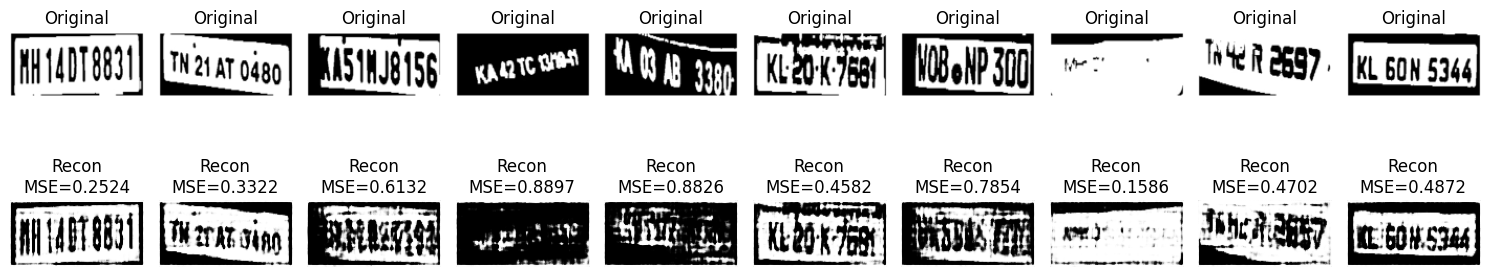

In [51]:
import torch.nn.functional as F

def visualize_reconstructions_from_model(model, dataloader, device='cpu', n=10):
    model.eval()
    model.to(device)
    for x, _ in dataloader:
        x = x[:n].to(device)  # ارسال به GPU
        with torch.no_grad():
            recon_x, mu, logvar = model(x)

        fig, axes = plt.subplots(2, n, figsize=(15, 4))
        for i in range(n):
            axes[0, i].imshow(x[i][0].cpu().numpy(), cmap='gray')  # بازگشت به CPU برای plot
            axes[0, i].set_title("Original")
            axes[0, i].axis('off')

            axes[1, i].imshow(recon_x[i][0].cpu().numpy(), cmap='gray')
            error = F.mse_loss(recon_x[i], x[i]).item()
            axes[1, i].set_title(f"Recon\nMSE={error:.4f}")
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()
        break  # فقط یک batch نمایش بده
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_reconstructions_from_model(model, test_loader, device=device)


In [52]:
def find_high_error_samples(model, dataloader, threshold=0.8, device='cpu', n_show=6):
    model.eval()
    model.to(device)

    high_error_imgs = []
    errors = []

    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            batch_errors = F.mse_loss(recon_x, x, reduction='none')
            batch_errors = batch_errors.view(x.size(0), -1).mean(dim=1)  # (B,)
            
            for i, err in enumerate(batch_errors):
                if err.item() > threshold:
                    high_error_imgs.append((x[i].cpu(), recon_x[i].cpu(), err.item()))
                    errors.append(err.item())
    
    # نمایش نمونه‌های با خطای زیاد
    for i, (orig, recon, err) in enumerate(high_error_imgs[:n_show]):
        plt.figure(figsize=(4,2))
        plt.subplot(1,2,1)
        plt.imshow(orig[0].numpy(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(recon[0].numpy(), cmap='gray')
        plt.title(f"Recon\nMSE={err:.4f}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    print(f"✅ Found {len(high_error_imgs)} high-error samples (MSE > {threshold})")

# اجرا
find_high_error_samples(model, test_loader, threshold=1.0, device=device)


✅ Found 0 high-error samples (MSE > 1.0)


In [53]:
# اجرای بررسی بازسازی‌های ضعیف با آستانه MSE مشخص
find_high_error_samples(
    model=model,
    dataloader=test_loader,
    threshold=1.0,   # آستانه خطای بازسازی
    device=device,
    n_show=6         # چند نمونه نشون بده
)


✅ Found 0 high-error samples (MSE > 1.0)


In [54]:
def visualize_latent_space(model, dataloader, device='cpu', method='tsne'):
    model.eval()
    model.to(device)

    all_mu = []
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            mu, _ = model.encoder(x)
            all_mu.append(mu.cpu().numpy())

    all_mu = np.concatenate(all_mu, axis=0)

    if method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30)
    else:
        reducer = PCA(n_components=2)

    embeddings_2d = reducer.fit_transform(all_mu)

    plt.figure(figsize=(8,6))
    sns.scatterplot(x=embeddings_2d[:,0], y=embeddings_2d[:,1])
    plt.title(f"Latent space ({method.upper()})")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.grid(True)
    plt.show()


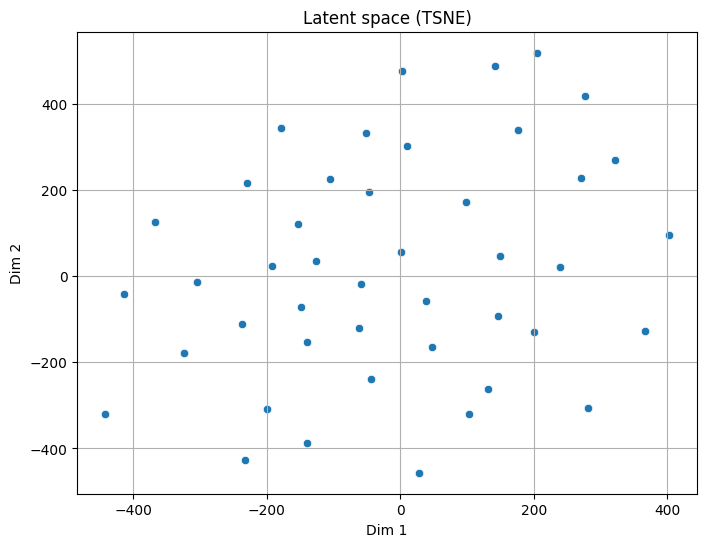

In [55]:
# تحلیل و نمایش فضای نهفته با t-SNE
visualize_latent_space(
    model=model,
    dataloader=test_loader,
    device=device,
    method='tsne'  # یا 'pca'
)


In [56]:
def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)  # (B,)

def analyze_kl_divergence(model, dataloader, device='cpu', n_show=6, threshold=80):
    model.eval()
    model.to(device)
    outliers = []

    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            mu, logvar = model.encoder(x)
            kl = kl_divergence(mu, logvar)  # (B,)
            for i in range(len(kl)):
                if kl[i].item() > threshold:
                    outliers.append((x[i].cpu(), kl[i].item()))

    # نمایش برخی موارد پرت
    for i in range(min(n_show, len(outliers))):
        img, kl_val = outliers[i]
        plt.imshow(img[0].numpy(), cmap='gray')
        plt.title(f"KL divergence: {kl_val:.2f}")
        plt.axis('off')
        plt.show()

    print(f"✅ {len(outliers)} images with KL divergence > {threshold}")


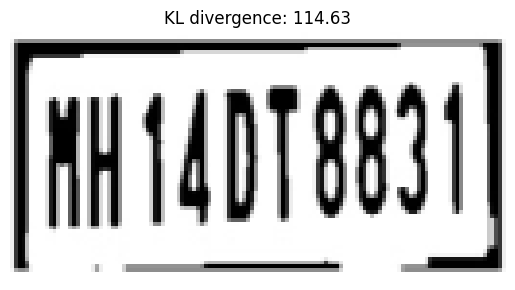

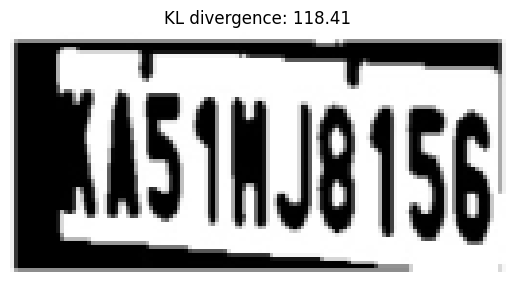

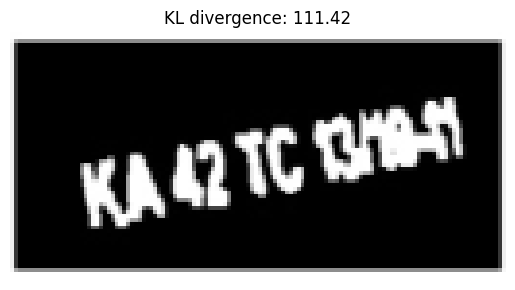

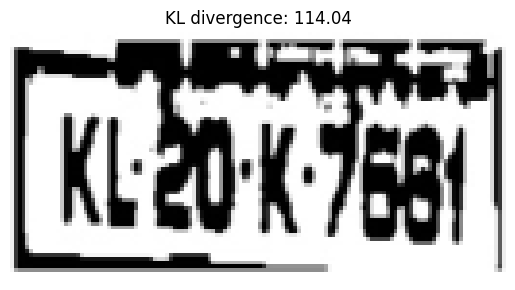

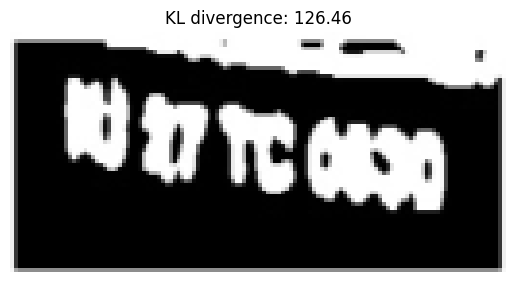

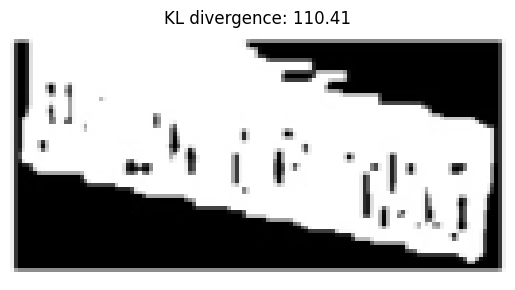

✅ 22 images with KL divergence > 110


In [57]:
# پیدا کردن داده‌هایی که KL divergence بالایی دارن
analyze_kl_divergence(
    model=model,
    dataloader=test_loader,
    device=device,
    n_show=6,
    threshold=110  # مقدار KL بالا که مشکوکه
)


In [58]:
import torch

def compute_entropy_from_logvar(logvar):
    """
    logvar: (B, latent_dim) - خروجی logvar از VAE
    Returns:
        entropy: (B,) - آنتروپی برای هر تصویر در batch
    """
    latent_dim = logvar.shape[1]
    entropy = 0.5 * (latent_dim * (1 + torch.log(torch.tensor(2 * torch.pi))) + torch.sum(logvar, dim=1))
    return entropy  # (B,)


In [59]:
model.eval()
entropy_list = []

for x, _ in test_loader:
    x = x.to(device)
    with torch.no_grad():
        _, mu, logvar = model(x)
        entropy = compute_entropy_from_logvar(logvar)
        entropy_list.extend(entropy.cpu().numpy())


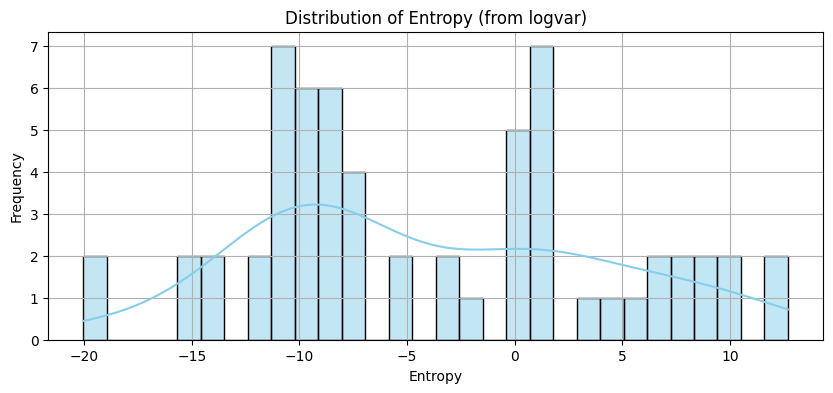

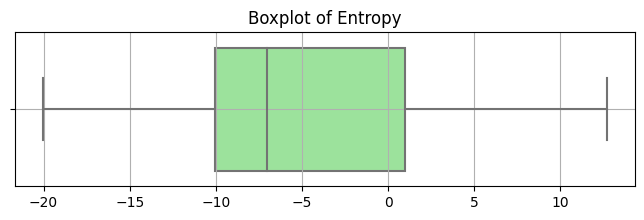

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# تبدیل به numpy array
entropy_array = np.array(entropy_list)

# 1️⃣ رسم هیستوگرام
plt.figure(figsize=(10, 4))
sns.histplot(entropy_array, bins=30, kde=True, color='skyblue')
plt.title("Distribution of Entropy (from logvar)")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 2️⃣ Boxplot برای نمایش outlierها
plt.figure(figsize=(8, 2))
sns.boxplot(x=entropy_array, color='lightgreen')
plt.title("Boxplot of Entropy")
plt.grid(True)
plt.show()


In [61]:
# # محاسبه IQR
# q1 = np.percentile(entropy_array, 25)
# q3 = np.percentile(entropy_array, 75)
# iqr = q3 - q1

# lower_bound = q1 - 1.5 * iqr
# upper_bound = q3 + 1.5 * iqr

# # ایندکس‌های داده‌های مشکوک
# low_entropy_indices = np.where(entropy_array < lower_bound)[0]
# high_entropy_indices = np.where(entropy_array > upper_bound)[0]

# print(f"⚠️ {len(low_entropy_indices)} samples have unusually low entropy.")
# print(f"⚠️ {len(high_entropy_indices)} samples have unusually high entropy.")

low_thresh = np.percentile(entropy_array, 10)  # پایین‌ترین 10 درصد
high_thresh = np.percentile(entropy_array, 80)  # بالاترین 10 درصد

low_entropy_indices = np.where(entropy_array < low_thresh)[0]
high_entropy_indices = np.where(entropy_array > high_thresh)[0]

print(f"🔍 {len(low_entropy_indices)} samples in lowest 10% entropy.")
print(f"🔍 {len(high_entropy_indices)} samples in highest 10% entropy.")


🔍 6 samples in lowest 10% entropy.
🔍 12 samples in highest 10% entropy.


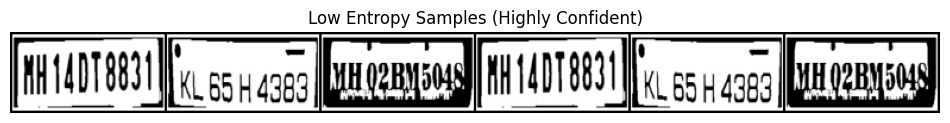

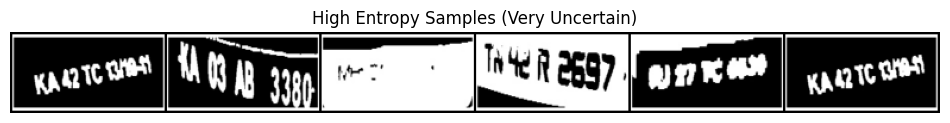

In [62]:
from torchvision.utils import make_grid

def show_images_by_indices(dataset, indices, title):
    images = [dataset[i][0] for i in indices[:6]]  # فقط ۶ تصویر
    grid = make_grid(images, nrow=8, normalize=True)
    plt.figure(figsize=(12, 2))
    plt.imshow(grid.permute(1, 2, 0).numpy(), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# فرض بر این که test_data = ImageFolder(..., transform=...)
show_images_by_indices(test_data, low_entropy_indices, "Low Entropy Samples (Highly Confident)")
show_images_by_indices(test_data, high_entropy_indices, "High Entropy Samples (Very Uncertain)")
